In [ ]:
import random
from numpy.random import choice
from matplotlib import pyplot as plt


class VariableActionSet:
    def __init__(self, action_number, reward_rate, penalty_rate):
        self.action_number = action_number
        self.action_probaility = [(1 / action_number)
                                  for i in range(self.action_number)]

        self.reward_rate = reward_rate
        self.penalty_rate = penalty_rate

        self.last_action = 0
        self.last_sub_action_list = None
        self.sub_action_probability = None
        self.sub_action_probability_sum = 0

        self.sum_probability = []
        self.visual_action_probability = [[]
                                          for _ in range(self.action_number)]

    # *****************************************************************************************
    def choose_action(self, sub_action_list):
        self.sub_action_probability_sum = 0
        self.sub_action_probability = [0 for i in range(self.action_number)]  # NOQA : init sub action probability
        self.last_sub_action_list = sub_action_list

        for action in sub_action_list:
            self.sub_action_probability_sum += self.action_probaility[action]

        for action in sub_action_list:
            self.sub_action_probability[action] = self.action_probaility[action] / \
                self.sub_action_probability_sum

        self.last_action = self.__roulette_wheel_selection(
            self.sub_action_probability)

        return self.last_action

    # *****************************************************************************************
    def receive_environment_signal(self, beta):
        self.__update_action_probability(beta)
        self.__rescale_action_probability_vector()

        return

        # *****************************************************************************************
    def visualization_calculations(self):
        self.sum_probability.append(sum(self.action_probaility))

        for action in range(self.action_number):
            self.visual_action_probability[action].append(
                self.action_probaility[action])

    # *****************************************************************************************
    def visualize_sum_probability_data(self, iteration_number):
        x_values = [i for i in range(iteration_number)]

        plt.title('Sum Probability')
        plt.xlabel('iteration')
        plt.ylabel('sum')

        plt.plot(x_values, self.sum_probability)
        plt.show()

        # *****************************************************************************************
    def visualize_action_probability_data(self, iteration_number):
        x_values = [i for i in range(iteration_number)]

        plt.plot(
            x_values, self.visual_action_probability[0], color='r', label='action 0')
        plt.plot(
            x_values, self.visual_action_probability[1], color='b', label='action 1')

        plt.title('Action Probability')
        plt.xlabel('iteration')
        plt.ylabel('probability')

        plt.legend(loc="upper left")

        plt.show()

    # *****************************************************************************************

    def __roulette_wheel_selection(self, probability_list):
        sum = 0
        random_number = random.uniform(0, 1)

        for index, probability in enumerate(probability_list):
            sum += probability

            if random_number <= sum:
                return index

        return probability_list.len() - 1

    # *****************************************************************************************
    def __update_action_probability(self, beta):
        num_of_available_action = sum(
            x != 0 for x in self.sub_action_probability)

        for action in range(len(self.sub_action_probability)):
            if action != self.last_action and self.sub_action_probability[action] != 0:
                self.sub_action_probability[action] = self.sub_action_probability[action] - self.reward_rate * (
                    1 - beta) * self.sub_action_probability[action] + self.penalty_rate * beta * ((1 / (num_of_available_action - 1)) - self.sub_action_probability[action])
            elif action == self.last_action and self.sub_action_probability[action] != 0:
                self.sub_action_probability[action] = self.sub_action_probability[action] + self.reward_rate * (1 - beta) * (
                    1 - self.sub_action_probability[action]) - self.penalty_rate * beta * self.sub_action_probability[action]
        return

    # *****************************************************************************************
    def __rescale_action_probability_vector(self):
        for action in range(len(self.sub_action_probability)):
            if self.sub_action_probability[action] != 0:
                self.action_probaility[action] = self.sub_action_probability[action] * \
                    self.sub_action_probability_sum

        return


In [ ]:
import sys
import os
# sys.path.insert(0, os.path.abspath(
#     os.path.join(os.path.dirname(__file__), '..')))

# from variable_action_set import VariableActionSet  # NOQA


class AsymmetricArm:
    def __init__(self, state_number, reward_rate, penalty_rate, max_state_number, arm_manager):
        self.__fsla_state_number = state_number
        self.__fsla_depth_status = 1
        self.__fsla_state_transition_counter = 0
        self.__fsla_depth_transition_counter = 0
        self.__fsla_min_state = 1
        self.__fsla_max_state = max_state_number

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        '''
            grow --> Action 0
            stop --> Action 1
            shrink --> Action 2
        '''
        self.__variable_action_set_action_number = 3
        self.__variable_action_set = VariableActionSet(
            self.__variable_action_set_action_number, self.__reward_rate, self.__penalty_rate)

        self.__arm_manager = arm_manager
        self.__first_action_switching = True

    # *****************************************************************************************
    def set_depth_status(self, value):
        self.__fsla_depth_status = value

    # *****************************************************************************************
    def set_state_transition_counter(self, value):
        self.__fsla_state_transition_counter = value

    # *****************************************************************************************
    def set_depth_transition_counter(self, value):
        self.__fsla_depth_transition_counter = value

    # *****************************************************************************************
    @property
    def state_number(self):
        return self.__fsla_state_number

    # *****************************************************************************************
    def receive_environment_signal(self, beta):
        if beta == 1:
            return self.__punish_automata()
        else:
            return self.__suprise_automata()

    # *****************************************************************************************
    def __suprise_automata(self):
        if self.__fsla_depth_status < self.__fsla_state_number:
            self.__fsla_depth_status += 1

        self.__fsla_state_transition_counter += 1

        if self.__is_fsla_on_depth():
            self.__fsla_depth_transition_counter += 1

        return False

    # *****************************************************************************************
    def __punish_automata(self):
        if self.__fsla_depth_status > 1:
            self.__fsla_depth_status -= 1

            self.__fsla_state_transition_counter += 1

            return False

        else:
            if not self.__first_action_switching:
                self.__evaluate_variable_action_set()
            else:
                self.__first_action_switching = False

            self.__update_fsla_depth()

            self.__fsla_depth_status = 1

            self.__fsla_state_transition_counter = 1
            self.__fsla_depth_transition_counter = 0

            self.__arm_manager.arm_switching_notification()

            return True

    # *****************************************************************************************
    def __is_fsla_on_depth(self):
        return self.__fsla_depth_status == self.__fsla_state_number

    # *****************************************************************************************
    def __evaluate_variable_action_set(self):
        variable_action_set_beta = 1 - (self.__fsla_depth_transition_counter / self.__fsla_state_transition_counter)  # NOQA

        self.__variable_action_set.receive_environment_signal(
            variable_action_set_beta)

        return

    # *****************************************************************************************
    def __update_fsla_depth(self):
        new_depth_decision = 0

        if self.__fsla_state_number == self.__fsla_max_state:
            new_depth_decision = self.__variable_action_set.choose_action([1, 2])  # NOQA
        elif self.__fsla_state_number == self.__fsla_min_state:
            new_depth_decision = self.__variable_action_set.choose_action([0, 1])  # NOQA
        else:
            new_depth_decision = self.__variable_action_set.choose_action([0, 1, 2])  # NOQA

        if new_depth_decision == 0:
            self.__fsla_state_number += 1  # Grow
        # elif new_depth_decision == 1:
        #     # Do Nothing --> Stop
        elif new_depth_decision == 2:
            self.__fsla_state_number -= 1  # Shrink

        return


In [ ]:
import random
from numpy.random import choice


class AsymmetricArmManager:
    def __init__(self, arm_number):
        self.__arm_number = arm_number

        self.__chosen_arm = 0

    # *****************************************************************************************
    def chosen_arm(self, sub_action_list):
        switch = self.__arm_switching_by_scaling(sub_action_list)

        return self.__chosen_arm, switch

    # *****************************************************************************************
    @property
    def random_chosen_arm(self):
        self.__chosen_arm = random.randint(0, self.__arm_number-1)

        return self.__chosen_arm

    # *****************************************************************************************
    def arm_switching_notification(self):
        self.__choose_new_arm_clockwise()

        return

    # *****************************************************************************************
    def __choose_new_arm_clockwise(self):
        if self.__chosen_arm < self.__arm_number - 1:
            self.__chosen_arm += 1
        else:
            self.__chosen_arm = 0

        return

    # *****************************************************************************************
    def __arm_switching_by_scaling(self, sub_action_list):
        for action in sub_action_list:
            if self.__chosen_arm == action:
                return False

        self.__choose_new_arm_clockwise()

        return True


In [ ]:
from matplotlib import pyplot as plt
import sys
import os

# from asymmetric.asymmetric_arm_manager import *  # NOQA
# from asymmetric.asymmetric_arm import *  # NOQA


class AsymmetricVariableDepthHybrid:
    def __init__(self, action_number, state_number_list, reward_rate, penalty_rate, max_state_number):
        self.__arm_number = action_number
        self.__init_state_number = state_number_list

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        self.__chosen_arm = 0
        self.__arm_manager = AsymmetricArmManager(self.__arm_number)

        self.__arm_list = [AsymmetricArm(
            self.__init_state_number[i], self.__reward_rate, self.__penalty_rate, max_state_number, self.__arm_manager) for i in range(self.__arm_number)]

        self.__total_number_of_rewards = []
        self.__total_number_of_action_switching = []

        self.__arm_selection_status = [[]
                                       for _ in range(self.__arm_number)]

    # *****************************************************************************************
    @property
    def total_number_of_rewards(self):
        return self.__total_number_of_rewards

    # *****************************************************************************************
    @property
    def total_number_of_action_switching(self):
        return self.__total_number_of_action_switching

    # *****************************************************************************************
    @property
    def depth_vector(self):
        depth_vector = []
        for arm in self.__arm_list:
            depth_vector.append(arm.state_number)

        return depth_vector

    # *****************************************************************************************
    def get_action_selection_status(self, action_number):
        return self.__arm_selection_status[action_number]

    # *****************************************************************************************
    def choose_action(self, sub_action_list):
        self.__chosen_arm, switch = self.__arm_manager.chosen_arm(
            sub_action_list)

        if switch:
            self.__arm_list[self.__chosen_arm].set_depth_status(1)
            self.__arm_list[self.__chosen_arm].set_state_transition_counter(1)
            self.__arm_list[self.__chosen_arm].set_depth_transition_counter(0)

        return self.__chosen_arm

    # *****************************************************************************************
    def choose_random_action(self):
        self.__chosen_arm = self.__arm_manager.random_chosen_arm
        self.__arm_list[self.__chosen_arm].set_depth_status(1)

        return self.__chosen_arm

    # *****************************************************************************************
    def receive_environment_signal(self, beta):
        action_switch = self.__arm_list[self.__chosen_arm].receive_environment_signal(
            beta)

        if beta == 1:
            self.__total_number_of_rewards.append(
                0 + self.__total_number_of_rewards[-1] if len(self.__total_number_of_rewards) > 0 else 0)

            if action_switch:
                self.__total_number_of_action_switching.append(
                    1 + self.__total_number_of_action_switching[-1] if len(self.__total_number_of_action_switching) > 0 else 1)
            else:
                self.__total_number_of_action_switching.append(
                    0 + self.__total_number_of_action_switching[-1] if len(self.__total_number_of_action_switching) > 0 else 0)
        else:
            self.__total_number_of_rewards.append(
                1 + self.__total_number_of_rewards[-1] if len(self.__total_number_of_rewards) > 0 else 1)
            self.__total_number_of_action_switching.append(
                0 + self.__total_number_of_action_switching[-1] if len(self.__total_number_of_action_switching) > 0 else 0)

        return

    # *****************************************************************************************
    def visualization_calculations(self):
        for arm in range(self.__arm_number):
            if arm == self.__chosen_arm:
                self.__arm_selection_status[arm].append(
                    1 + self.__arm_selection_status[arm][-1] if len(self.__arm_selection_status[arm]) > 0 else 1)
            else:
                self.__arm_selection_status[arm].append(
                    0 + self.__arm_selection_status[arm][-1] if len(self.__arm_selection_status[arm]) > 0 else 0)


In [ ]:
import random
from numpy.random import choice
from matplotlib import pyplot as plt

# import sys
# import os
# sys.path.insert(0, os.path.abspath(
#     os.path.join(os.path.dirname(__file__), '..')))

# from learning_automata.variable_action_set import VariableActionSet  # NOQA


class SymmetricVariableDepthHybrid:
    def __init__(self, action_number, state_number, reward_rate, penalty_rate, max_state_number):
        self.fsla_action_number = action_number
        self.fsla_state_number = state_number

        self.fsla_chosen_action = 0
        self.fsla_chosen_action_depth_status = 0
        self.fsla_state_transition_counter = 0
        self.fsla_depth_transition_counter = 0
        self.fsla_min_state = 1
        self.fsla_max_state = max_state_number

        '''
            grow --> Action 0
            stop --> Action 1
            shrink --> Action 2
        '''
        self.variable_action_set_action_number = 3
        self.variable_action_set = VariableActionSet(
            self.variable_action_set_action_number, reward_rate, penalty_rate)
        self.variable_action_set_first_run = True

        self.total_number_of_rewards = []
        self.total_number_of_action_switching = []

        self.action_selection_status = [[]
                                        for _ in range(self.fsla_action_number)]

    # *****************************************************************************************
    def choose_action(self, sub_action_list):
        self.__action_switching_by_scaling(sub_action_list)

        return self.fsla_chosen_action

    # *****************************************************************************************
    def choose_random_action(self):
        # Choose random action for first running
        self.chosen_action = random.randint(0, self.fsla_action_number-1)
        self.fsla_chosen_action_depth_status = 1

        return self.fsla_chosen_action

    # *****************************************************************************************
    def receive_environment_signal(self, beta):
        if beta == 1:
            self.__punish_automata()
            self.total_number_of_rewards.append(
                0 + self.total_number_of_rewards[-1] if len(self.total_number_of_rewards) > 0 else 0)
        else:
            self.__suprise_automata()

            self.total_number_of_rewards.append(
                1 + self.total_number_of_rewards[-1] if len(self.total_number_of_rewards) > 0 else 1)
            self.total_number_of_action_switching.append(
                0 + self.total_number_of_action_switching[-1] if len(self.total_number_of_action_switching) > 0 else 0)
        return

    # *****************************************************************************************
    def visualization_calculations(self):
        for action in range(self.fsla_action_number):
            if action == self.fsla_chosen_action:
                self.action_selection_status[action].append(
                    1 + self.action_selection_status[action][-1] if len(self.action_selection_status[action]) > 0 else 1)
            else:
                self.action_selection_status[action].append(
                    0 + self.action_selection_status[action][-1] if len(self.action_selection_status[action]) > 0 else 0)

    # *****************************************************************************************
    @property
    def get_total_number_of_rewards(self):
        return self.total_number_of_rewards

    # *****************************************************************************************
    @property
    def get_total_number_of_action_switching(self):
        return self.total_number_of_action_switching

    # *****************************************************************************************
    def get_action_selection_status(self, action_number):
        return self.action_selection_status[action_number]

    # *****************************************************************************************
    def __suprise_automata(self):
        if self.fsla_chosen_action_depth_status < self.fsla_state_number:
            self.fsla_chosen_action_depth_status += 1

        self.fsla_state_transition_counter += 1
        if self.__is_fsla_on_depth():
            self.fsla_depth_transition_counter += 1

        return

    # *****************************************************************************************
    def __punish_automata(self):
        if self.fsla_chosen_action_depth_status > 1:
            self.fsla_chosen_action_depth_status -= 1

            self.fsla_state_transition_counter += 1

            self.total_number_of_action_switching.append(
                0 + self.total_number_of_action_switching[-1] if len(self.total_number_of_action_switching) > 0 else 0)
        else:
            if not self.variable_action_set_first_run:
                self.__evaluate_variable_action_set()
            else:
                self.variable_action_set_first_run = False

            self.__action_switching()

        return

    # *****************************************************************************************
    def __is_fsla_on_depth(self):
        return self.fsla_chosen_action_depth_status == self.fsla_state_number

    # *****************************************************************************************
    def __choose_new_action_clockwise(self):
        if self.fsla_chosen_action < self.fsla_action_number - 1:
            self.fsla_chosen_action += 1
        else:
            self.fsla_chosen_action = 0

        self.fsla_chosen_action_depth_status = 1

        return

    # *****************************************************************************************
    def __action_switching(self):
        self.__choose_new_action_clockwise()
        self.__update_fsla_depth()

        self.fsla_state_transition_counter = 1
        self.fsla_depth_transition_counter = 0

        self.total_number_of_action_switching.append(
            1 + self.total_number_of_action_switching[-1] if len(self.total_number_of_action_switching) > 0 else 1)

        return

    # *****************************************************************************************
    def __evaluate_variable_action_set(self):
        variable_action_set_beta = 1 - (self.fsla_depth_transition_counter / self.fsla_state_transition_counter)  # NOQA

        self.variable_action_set.receive_environment_signal(
            variable_action_set_beta)

        return

    # *****************************************************************************************
    def __update_fsla_depth(self):
        new_depth_decision = 0

        if self.fsla_state_number == self.fsla_max_state:
            new_depth_decision = self.variable_action_set.choose_action([1, 2])
        elif self.fsla_state_number == self.fsla_min_state:
            new_depth_decision = self.variable_action_set.choose_action([0, 1])
        else:
            new_depth_decision = self.variable_action_set.choose_action([0, 1, 2])  # NOQA

        if new_depth_decision == 0:
            self.fsla_state_number += 1  # Grow
        # elif new_depth_decision == 1:
        #     # Do Nothing --> Stop
        elif new_depth_decision == 2:
            self.fsla_state_number -= 1  # Shrink

        return

    # *****************************************************************************************
    def __action_switching_by_scaling(self, sub_action_list):
        for action in sub_action_list:
            if self.fsla_chosen_action == action:
                return

        self.__choose_new_action_clockwise()

        self.fsla_state_transition_counter = 1
        self.fsla_depth_transition_counter = 0

        return


In [ ]:
from enum import Enum


class BlockCreationStatus(Enum):
    EndTow = 1,
    EndTimeWindow = 2,
    Normal = 3


In [ ]:
from enum import IntEnum


class LearningAutomataType(IntEnum):
    VASLA = 1,
    SVDHLA = 2,
    AVDHLA = 3


In [ ]:
import random


class Tow:
    def __init__(self, min_block, max_block):
        self.min_block = min_block
        self.max_block = max_block

        self.block_number = 0

    def choose_block_number_in_tow(self):
        self.block_number = random.randint(self.min_block, self.max_block)

    def create_a_block(self):
        self.block_number -= 1

    def get_current_block_number(self):
        return self.block_number


In [ ]:
import sys
import os
# sys.path.insert(0, os.path.abspath(
#     os.path.join(os.path.dirname(__file__), '..')))




class TimeWindow:
    def __init__(self, tow_number, min_tow_block_number, max_tow_block_number):
        self.tow_number = tow_number

        self.min_tow_block_number = min_tow_block_number
        self.max_tow_block_number = max_tow_block_number

        self.tows = [Tow(min_tow_block_number, max_tow_block_number)
                     for _ in range(tow_number)]

        for tow in self.tows:
            tow.choose_block_number_in_tow()

        self.current_tow = 0

    def create_a_block(self):
        if self.current_tow < self.tow_number:
            self.tows[self.current_tow].create_a_block()
            if self.tows[self.current_tow].get_current_block_number() > 0:
                return BlockCreationStatus.Normal

            elif self.tows[self.current_tow].get_current_block_number() == 0:
                self.current_tow += 1
                return BlockCreationStatus.EndTow

        return BlockCreationStatus.EndTimeWindow

    def get_average_tow(self):
        return (self.min_tow_block_number + self.max_tow_block_number) / 2


In [ ]:
import sys
import os
# sys.path.insert(0, os.path.abspath(
#     os.path.join(os.path.dirname(__file__), '..')))


from matplotlib import pyplot as plt  # NOQA

# Nik Defense

class NikDefense:

    ds = 6
    def __init__(self, tow_number, min_tow_block_number, max_tow_block_number,
                 reward_rate, penalty_rate, min_k, max_k, automata_type, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.ds_count = 0
        self.weight_size = 5000

        self.__tow_number = tow_number
        self.__min_tow_block_number = min_tow_block_number
        self.__max_tow_block_number = max_tow_block_number

        self.time_window = TimeWindow(
            tow_number, min_tow_block_number, max_tow_block_number)

        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.__predicted_K = 2

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.min_K = min_k
        self.max_K = max_k

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        self.__automata_type = automata_type
        self.vasla = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision = True

    # *****************************************************************************************
    @property
    def alpha(self):
        return self._alpha

    # *****************************************************************************************
    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    # *****************************************************************************************
    @property
    def gamma(self):
        return self._gamma

    # *****************************************************************************************
    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    # *****************************************************************************************
    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    # *****************************************************************************************
    @property
    def stale_block(self):
        return self.__total_stale_block

    # *****************************************************************************************
    @property
    def double_spending_numbers(self):
        return self.ds_count

    # *****************************************************************************************
    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    # *****************************************************************************************
    def start_simulate(self, iteration):
        # self.log('start simulating')

        self.__iteration_number = iteration

        for _ in range(iteration):
            # self.log("found a new block")

            self.calculating_delta()

            random_number = random.random()

            # Mining Process
            if random_number < self._alpha:
                self.calculating_weight(True)
                self.start_selfish_mining()
            else:
                self.calculating_weight(False)
                self.start_honest_mining()

            block_creation_response = self.time_window.create_a_block()
            if block_creation_response == BlockCreationStatus.EndTow:
                # self.chain_evaluation()
                # self.reset_tow()

                if self.__weight_decision == True:
                    self.__weight_decision_number += 1
                    self.__weight_decision = False

                self.__current_block_tow = 1
            elif block_creation_response == BlockCreationStatus.EndTimeWindow:
                self.time_window = TimeWindow(
                    self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)
                # self.chain_evaluation()
                # self.reset_tow()

                # self.VASLA_decision()
                # self.SVDHLA_decision()
                # self.AVDHLA_decision()
                self.automata_decision()
                self.__first_la_decision = False

                self.__current_block_tow = 1
            else:
                self.__current_block_tow += 1

        self.calculating_output()

        return

    # *****************************************************************************************
    def start_selfish_mining(self):
        # self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            self.chain_evaluation()
            self.reset_attack()

        return

    # *****************************************************************************************
    def start_honest_mining(self):
        # self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 0 and self.__private_chain_length == 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 1:
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == self.__predicted_K + 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta > self.__predicted_K + 1:
            pass

        return

    # *****************************************************************************************
    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        # self.log('delta is : {}'.format(self.__delta))

        return

    # *****************************************************************************************
    def calculating_weight(self, is_private_block):
        if is_private_block:
            self.__private_chain_weight_list[self.__private_chain_length] = 1
            self.__public_chain_weight_list[self.__private_chain_length] = 0
        else:
            self.__private_chain_weight_list[self.__public_chain_length] = 0
            self.__public_chain_weight_list[self.__public_chain_length] = 1
            pass

        return

    # *****************************************************************************************
    def chain_evaluation(self):
        if self.__private_chain_length - self.__public_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__selfish_miners_win_block += self.__private_chain_length
            if self.__public_chain_length > self.ds:
                self.ds_count += 1
        elif self.__public_chain_length - self.__private_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__honest_miners_win_block += self.__public_chain_length
        else:
            self.__weight_decision = True

            # Decision based on Wight
            self.__private_chain_weight = sum(self.__private_chain_weight_list)
            self.__public_chain_weight = sum(self.__public_chain_weight_list)

            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                if self.__public_chain_length > self.ds:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    if self.__public_chain_length > self.ds:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length

        return

    # *****************************************************************************************
    def automata_decision(self):
        if self.__automata_type == LearningAutomataType.VASLA:
            self.VASLA_decision()
        elif self.__automata_type == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision()
        elif self.__automata_type == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision()

        return

    # *****************************************************************************************
    def VASLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            self.vasla.receive_environment_signal(beta)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.vasla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.vasla.choose_action([1, 2])
        else:
            chosen_action = self.vasla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def SVDHLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            if beta < 0.5:
                self.svdhla.receive_environment_signal(0)
            else:
                self.svdhla.receive_environment_signal(1)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.svdhla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.svdhla.choose_action([1, 2])
        else:
            chosen_action = self.svdhla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def AVDHLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            if beta < 0.5:
                self.avdhla.receive_environment_signal(0)
            else:
                self.avdhla.receive_environment_signal(1)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.avdhla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.avdhla.choose_action([1, 2])
        else:
            chosen_action = self.avdhla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    # *****************************************************************************************
    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('Nik honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('Nik selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('Nik total mined block is : {}'.format(self.__total_mined_block))
        print('Nik total stale block is : {}'.format(self.__total_stale_block))

        print('Nik honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('Nik selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('Nik honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('Nik selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)
        # self.ds_count = 0

        print('********************************************')

        return

    # *****************************************************************************************
    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    # *****************************************************************************************
    def reset_tow(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__current_block_tow = 1

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset_attack(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0
        self.ds_count = 0
        self.time_window = TimeWindow(
            self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.__predicted_K = 2

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.vasla = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision = True

        return

    # *****************************************************************************************
    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Nik Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [ ]:


class NikDefense_12:

    ds = 12
    def __init__(self, tow_number, min_tow_block_number, max_tow_block_number,
                 reward_rate, penalty_rate, min_k, max_k, automata_type, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.ds_count = 0
        self.weight_size = 5000

        self.__tow_number = tow_number
        self.__min_tow_block_number = min_tow_block_number
        self.__max_tow_block_number = max_tow_block_number

        self.time_window = TimeWindow(
            tow_number, min_tow_block_number, max_tow_block_number)

        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.__predicted_K = 2

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.min_K = min_k
        self.max_K = max_k

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        self.__automata_type = automata_type
        self.vasla = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision = True

    # *****************************************************************************************
    @property
    def alpha(self):
        return self._alpha

    # *****************************************************************************************
    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    # *****************************************************************************************
    @property
    def gamma(self):
        return self._gamma

    # *****************************************************************************************
    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    # *****************************************************************************************
    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    # *****************************************************************************************
    @property
    def stale_block(self):
        return self.__total_stale_block

    # *****************************************************************************************
    @property
    def double_spending_numbers(self):
        return self.ds_count

    # *****************************************************************************************
    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    # *****************************************************************************************
    def start_simulate(self, iteration):
        # self.log('start simulating')

        self.__iteration_number = iteration

        for _ in range(iteration):
            # self.log("found a new block")

            self.calculating_delta()

            random_number = random.random()

            # Mining Process
            if random_number < self._alpha:
                self.calculating_weight(True)
                self.start_selfish_mining()
            else:
                self.calculating_weight(False)
                self.start_honest_mining()

            block_creation_response = self.time_window.create_a_block()
            if block_creation_response == BlockCreationStatus.EndTow:
                # self.chain_evaluation()
                # self.reset_tow()

                if self.__weight_decision == True:
                    self.__weight_decision_number += 1
                    self.__weight_decision = False

                self.__current_block_tow = 1
            elif block_creation_response == BlockCreationStatus.EndTimeWindow:
                self.time_window = TimeWindow(
                    self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)
                # self.chain_evaluation()
                # self.reset_tow()

                # self.VASLA_decision()
                # self.SVDHLA_decision()
                # self.AVDHLA_decision()
                self.automata_decision()
                self.__first_la_decision = False

                self.__current_block_tow = 1
            else:
                self.__current_block_tow += 1

        self.calculating_output()

        return

    # *****************************************************************************************
    def start_selfish_mining(self):
        # self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            self.chain_evaluation()
            self.reset_attack()

        return

    # *****************************************************************************************
    def start_honest_mining(self):
        # self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 0 and self.__private_chain_length == 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 1:
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == self.__predicted_K + 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta > self.__predicted_K + 1:
            pass

        return

    # *****************************************************************************************
    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        # self.log('delta is : {}'.format(self.__delta))

        return

    # *****************************************************************************************
    def calculating_weight(self, is_private_block):
        if is_private_block:
            self.__private_chain_weight_list[self.__private_chain_length] = 1
            self.__public_chain_weight_list[self.__private_chain_length] = 0
        else:
            self.__private_chain_weight_list[self.__public_chain_length] = 0
            self.__public_chain_weight_list[self.__public_chain_length] = 1
            pass

        return

    # *****************************************************************************************
    def chain_evaluation(self):
        if self.__private_chain_length - self.__public_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__selfish_miners_win_block += self.__private_chain_length
            if self.__public_chain_length > self.ds:
                self.ds_count += 1
        elif self.__public_chain_length - self.__private_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__honest_miners_win_block += self.__public_chain_length
        else:
            self.__weight_decision = True

            # Decision based on Wight
            self.__private_chain_weight = sum(self.__private_chain_weight_list)
            self.__public_chain_weight = sum(self.__public_chain_weight_list)

            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                if self.__public_chain_length > self.ds:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    if self.__public_chain_length > self.ds:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length

        return

    # *****************************************************************************************
    def automata_decision(self):
        if self.__automata_type == LearningAutomataType.VASLA:
            self.VASLA_decision()
        elif self.__automata_type == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision()
        elif self.__automata_type == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision()

        return

    # *****************************************************************************************
    def VASLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            self.vasla.receive_environment_signal(beta)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.vasla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.vasla.choose_action([1, 2])
        else:
            chosen_action = self.vasla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def SVDHLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            if beta < 0.5:
                self.svdhla.receive_environment_signal(0)
            else:
                self.svdhla.receive_environment_signal(1)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.svdhla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.svdhla.choose_action([1, 2])
        else:
            chosen_action = self.svdhla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def AVDHLA_decision(self):
        if not self.__first_la_decision:
            beta = self.__weight_decision_number / self.__tow_number
            if beta < 0.5:
                self.avdhla.receive_environment_signal(0)
            else:
                self.avdhla.receive_environment_signal(1)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.avdhla.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.avdhla.choose_action([1, 2])
        else:
            chosen_action = self.avdhla.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Grow
            self.__predicted_K += 1
        elif chosen_action == 1:
            # Stop
            pass
        elif chosen_action == 2:
            # Shrink
            self.__predicted_K -= 1

        return

    # *****************************************************************************************
    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    # *****************************************************************************************
    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('Nik honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('Nik selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('Nik total mined block is : {}'.format(self.__total_mined_block))
        print('Nik total stale block is : {}'.format(self.__total_stale_block))

        print('Nik honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('Nik selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('Nik honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('Nik selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)
        # self.ds_count = 0

        print('********************************************')

        return

    # *****************************************************************************************
    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    # *****************************************************************************************
    def reset_tow(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__current_block_tow = 1

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset_attack(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0
        self.ds_count = 0
        self.time_window = TimeWindow(
            self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.__predicted_K = 2

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.vasla = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision = True

        return

    # *****************************************************************************************
    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Nik Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [ ]:
import sys
import os
import random  # NOQA
from matplotlib import pyplot as plt  # NOQA
import numpy as np


class SDTLA:

    old_tot = 0
    old_tot_z = 0
    old = 0
    old_z = 0
    stale_blocks = 0
    ds_count = 0
    def __init__(self, tow_number, min_tow_block_number, max_tow_block_number,
                 reward_rate, penalty_rate, min_k, max_k, min_z, max_z, automata_type_z, automata_type_k, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.z = 3
        self.totz = 0
        self.cntz = 0
        self.weight_size = 5000

        self.__tow_number = tow_number
        self.__min_tow_block_number = min_tow_block_number
        self.__max_tow_block_number = max_tow_block_number

        self.time_window = TimeWindow(
            tow_number, min_tow_block_number, max_tow_block_number)

        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.__predicted_K = 2

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.min_K = min_k
        self.max_K = max_k

        self.min_Z = min_z
        self.max_Z = max_z

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        self.__automata_type_z = automata_type_z
        self.__automata_type_k = automata_type_k
        self.vasla_z = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.vasla_k = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_z = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.svdhla_k = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_z = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_k = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_z = True
        self.__first_la_decision_k = True

    # *****************************************************************************************
    @property
    def alpha(self):
        return self._alpha

    # *****************************************************************************************
    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    # *****************************************************************************************
    @property
    def gamma(self):
        return self._gamma

    # *****************************************************************************************
    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    # *****************************************************************************************
    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    # *****************************************************************************************
    @property
    def stale_block(self):
        return self.__total_stale_block

    # *****************************************************************************************
    @property
    def double_spending_numbers(self):
        return self.ds_count

    # *****************************************************************************************
    @property
    def zcount_numbers(self):
        return self.totz

    # *****************************************************************************************
    @property
    def countcount(self):
        return self.cntz

    # *****************************************************************************************
    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    # *****************************************************************************************
    def start_simulate(self, iteration):
        # self.log('start simulating')

        self.__iteration_number = iteration

        for _ in range(iteration):
            # self.log("found a new block")

            self.calculating_delta()

            random_number = random.random()

            # Mining Process
            if random_number < self._alpha:
                self.calculating_weight(True)
                self.start_selfish_mining()
            else:
                self.calculating_weight(False)
                self.start_honest_mining()

            block_creation_response = self.time_window.create_a_block()
            if block_creation_response == BlockCreationStatus.EndTow:
                # self.chain_evaluation()
                # self.reset_tow()

                if self.__weight_decision == True:
                    self.__weight_decision_number += 1
                    self.__weight_decision = False

                self.__current_block_tow = 1
            elif block_creation_response == BlockCreationStatus.EndTimeWindow:
                self.time_window = TimeWindow(
                    self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)
                # self.chain_evaluation()
                # self.reset_tow()

                # self.VASLA_decision()
                # self.SVDHLA_decision()
                # self.AVDHLA_decision()
                self.automata_decision_k()
                self.automata_decision_z()
                self.__first_la_decision_k = False
                self.__first_la_decision_z = False

                self.__current_block_tow = 1
            else:
                self.__current_block_tow += 1

        self.calculating_output()

        return

    # *****************************************************************************************
    def start_selfish_mining(self):
        # self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            self.chain_evaluation()
            self.reset_attack()

        return

    # *****************************************************************************************
    def start_honest_mining(self):
        # self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 0 and self.__private_chain_length == 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 1:
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == self.__predicted_K + 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta > self.__predicted_K + 1:
            pass

        return

    # *****************************************************************************************
    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        # self.log('delta is : {}'.format(self.__delta))

        return

    # *****************************************************************************************
    def calculating_weight(self, is_private_block):
        if is_private_block:
            self.__private_chain_weight_list[self.__private_chain_length] = 1
            self.__public_chain_weight_list[self.__private_chain_length] = 0
        else:
            self.__private_chain_weight_list[self.__public_chain_length] = 0
            self.__public_chain_weight_list[self.__public_chain_length] = 1
            pass

        return

    # *****************************************************************************************
    def chain_evaluation(self):
        if self.__private_chain_length - self.__public_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__selfish_miners_win_block += self.__private_chain_length
            self.stale_blocks += self.__public_chain_length
            if self.__public_chain_length > self.z:
                self.ds_count += 1
        elif self.__public_chain_length - self.__private_chain_length >= self.__predicted_K:
            # Decision based on Length
            self.__honest_miners_win_block += self.__public_chain_length
            self.stale_blocks += self.__private_chain_length
        else:
            self.__weight_decision = True

            # Decision based on Wight
            amount = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
            self.__private_chain_weight = np.average(self.__private_chain_weight_list[0:10], weights=amount) * 7.75
            self.__public_chain_weight = np.average(self.__public_chain_weight_list[0:10], weights=amount) * 7.75
            if self.__private_chain_length > self.__public_chain_length >= 10:
                dif = self.__private_chain_length - self.__public_chain_length
                self.__private_chain_weight = self.__private_chain_weight + (0.5 * dif)
            if self.__public_chain_length > self.__private_chain_length >= 10:
                dif = self.__public_chain_length - self.__private_chain_length
                self.__public_chain_weight = self.__public_chain_weight + (0.5 * dif)

            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                self.stale_blocks += self.__public_chain_length
                if self.__public_chain_length > self.z:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
                self.stale_blocks += self.__private_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    self.stale_blocks += self.__public_chain_length
                    if self.__public_chain_length > self.z:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length
                    self.stale_blocks += self.__private_chain_length

        return

    # *****************************************************************************************
    def automata_decision_z(self):
        if self.__automata_type_z == LearningAutomataType.VASLA:
            self.VASLA_decision_z()
        elif self.__automata_type_z == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision_z()
        elif self.__automata_type_z == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision_z()

        return

    # *****************************************************************************************
    def automata_decision_k(self):
        if self.__automata_type_k == LearningAutomataType.VASLA:
            self.VASLA_decision_k()
        elif self.__automata_type_k == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision_k()
        elif self.__automata_type_k == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision_k()

        return

    # *****************************************************************************************
    def stale_block_numbers(self , old_tot):
        new = self.stale_blocks - old_tot
        return new

    # *****************************************************************************************
    def VASLA_decision_k(self):
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            beta = (new + 1) / ((self.old + new) + 1)
            beta = ((1 - beta) + (self.__weight_decision_number / self.__tow_number)) / 2
            self.vasla_k.receive_environment_signal(beta)
            self.old = new
            self.old_tot = self.stale_blocks

        #self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.vasla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.vasla_k.choose_action([1, 2])
        else:
            chosen_action = self.vasla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1

        print ("k = ",self.__predicted_K)
        return

    # *****************************************************************************************
    def SVDHLA_decision_k(self):
        temp = 0
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            new = new / self.__predicted_K
            beta1 = (new + 1) / ((self.old + new) + 1)
            temp = beta1
            beta1 = 1 - beta1
            beta2 = self.__weight_decision_number / self.__tow_number
            #print (beta)
            self.old = new
            self.old_tot = self.stale_blocks
            if beta1 > 0.5 and beta2 > 0.5:
                self.svdhla_k.receive_environment_signal(1)
            else:
                self.svdhla_k.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.svdhla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.svdhla_k.choose_action([1, 2])
        else:
            chosen_action = self.svdhla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1
        print("k = ", self.__predicted_K)
        return

    # *****************************************************************************************
    def AVDHLA_decision_k(self):
        temp = 0
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            new = new / self.__predicted_K
            beta1 = (new + 1) / ((self.old + new) + 1)
            temp = beta1
            beta1 = 1 - beta1
            beta2 = self.__weight_decision_number / self.__tow_number
            # print (beta)
            self.old = new
            self.old_tot = self.stale_blocks
            if beta1 > 0.5 and beta2 > 0.5:
                self.avdhla_k.receive_environment_signal(1)
            else:
                self.avdhla_k.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.avdhla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.avdhla_k.choose_action([1, 2])
        else:
            chosen_action = self.avdhla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1
        print("k = ", self.__predicted_K)
        return

    # *****************************************************************************************
    def VASLA_decision_z(self):
        if not self.__first_la_decision_z:
            new = self.stale_block_numbers(self.old_tot)
            beta = (new + 1) / ((self.old + new) + 1)
            beta = ((1 - beta) + (self.__weight_decision_number / self.__tow_number)) / 2
            self.vasla_z.receive_environment_signal(beta)
            self.old = new
            self.old_tot = self.stale_blocks

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z == self.min_Z:
            chosen_action = self.vasla_z.choose_action([0, 1])
        elif self.z == self.max_Z:
            chosen_action = self.vasla_z.choose_action([1, 2])
        else:
            chosen_action = self.vasla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if self.z < self.max_Z:
                self.z *= 4
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > self.min_Z:
                self.z /= 2
        #print(self.z)
        return

    # *****************************************************************************************
    def SVDHLA_decision_z(self):
        temp = 0
        if not self.__first_la_decision_z:
            new_z = self.stale_block_numbers(self.old_tot_z)
            new_z = new_z / self.z
            beta1z = (new_z + 1) / ((self.old + new_z) + 1)
            beta1z = 1 - beta1z

            self.oldz = new_z
            self.old_tot_z = self.stale_blocks
            if beta1z > 0.5:
                self.svdhla_z.receive_environment_signal(1)
            else:
                self.svdhla_z.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z <= self.min_Z:
            chosen_action = self.svdhla_z.choose_action([0, 1])
        elif self.z >= self.max_Z:
            chosen_action = self.svdhla_z.choose_action([1, 2])
        else:
            chosen_action = self.svdhla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if temp < 0.25:
                self.z *= 2
                self.z = int(self.z)
            elif temp >= 0.25 and self.z < self.max_Z:
                self.z += 2
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > 6 and self.z % 2 == 0:
                self.z /= 2
                self.z = int (self.z)
            elif self.z > self.min_Z:
                self.z -= 2
        print(self.z)
        self.totz += self.z
        self.cntz += 1
        return

    # *****************************************************************************************
    def AVDHLA_decision_z(self):
        temp = 0
        if not self.__first_la_decision_z:
            new_z = self.stale_block_numbers(self.old_tot_z)
            new_z = new_z / self.z
            beta1z = (new_z + 1) / ((self.old + new_z) + 1)
            # temp = beta1
            beta1z = 1 - beta1z
            # beta2 = self.__weight_decision_number / self.__tow_number
            # print (beta)
            self.oldz = new_z
            self.old_tot_z = self.stale_blocks
            if beta1z > 0.5:
                self.avdhla_z.receive_environment_signal(1)
            else:
                self.avdhla_z.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z <= self.min_Z:
            chosen_action = self.avdhla_z.choose_action([0, 1])
        elif self.z >= self.max_Z:
            chosen_action = self.avdhla_z.choose_action([1, 2])
        else:
            chosen_action = self.avdhla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if temp < 0.25:
                self.z *= 2
                self.z = int(self.z)
            elif temp >= 0.25 and self.z < self.max_Z:
                self.z += 2
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > 6 and self.z % 2 == 0:
                self.z /= 2
                self.z = int(self.z)
            elif self.z > self.min_Z:
                self.z -= 2
        print(self.z)
        self.totz += self.z
        self.cntz += 1
        return

    # *****************************************************************************************
    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    # *****************************************************************************************
    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('Nik honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('Nik selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('Nik total mined block is : {}'.format(self.__total_mined_block))
        print('Nik total stale block is : {}'.format(self.__total_stale_block))

        print('Nik honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('Nik selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('Nik honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('Nik selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)
        print ("stale blocks" , self.stale_blocks)


        print('********************************************')

        return

    # *****************************************************************************************
    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    # *****************************************************************************************
    def reset_tow(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__current_block_tow = 1

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset_attack(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0
        self.stale_blocks = 0
        self.old = 0
        self.old_tot = 0
        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.time_window = TimeWindow(
            self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.__predicted_K = 2
        self.z = 3
        self.totz = 0
        self.cntz = 0
        self.ds_count = 0

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.vasla_k = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_k = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_k = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_k = True
        self.vasla_z = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_z = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_z = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_z = True

        return

    # *****************************************************************************************
    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Nik Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [ ]:

from matplotlib import pyplot as plt  # NOQA
import numpy as np

class WVBM:

    old_tot = 0
    old_tot_z = 0
    old = 0
    old_z = 0
    stale_blocks = 0
    ds_count = 0
    def __init__(self, tow_number, min_tow_block_number, max_tow_block_number,
                 reward_rate, penalty_rate, min_k, max_k, min_z, max_z, automata_type_z, automata_type_k, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.z = 3
        self.totz = 0
        self.cntz = 0
        self.weight_size = 5000

        self.__tow_number = tow_number
        self.__min_tow_block_number = min_tow_block_number
        self.__max_tow_block_number = max_tow_block_number

        self.time_window = TimeWindow(
            tow_number, min_tow_block_number, max_tow_block_number)

        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.__predicted_K = 2
        self.z = 3

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0
        self.__private_chain_weight_threshold = 0
        self.__public_chain_weight_threshold = 0

        self.__current_block_tow = 1

        self.min_K = min_k
        self.max_K = max_k

        self.min_Z = min_z
        self.max_Z = max_z

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.__reward_rate = reward_rate
        self.__penalty_rate = penalty_rate

        self.__automata_type_z = automata_type_z
        self.__automata_type_k = automata_type_k
        self.vasla_z = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.vasla_k = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_z = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.svdhla_k = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_z = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_k = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_z = True
        self.__first_la_decision_k = True

    # *****************************************************************************************
    @property
    def alpha(self):
        return self._alpha

    # *****************************************************************************************
    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    # *****************************************************************************************
    @property
    def gamma(self):
        return self._gamma

    # *****************************************************************************************
    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    # *****************************************************************************************
    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    # *****************************************************************************************
    @property
    def stale_block(self):
        return self.__total_stale_block

    # *****************************************************************************************
    @property
    def double_spending_numbers(self):
        return self.ds_count

    # *****************************************************************************************
    @property
    def zcount_numbers(self):
        return self.totz

    # *****************************************************************************************
    @property
    def countcount(self):
        return self.cntz

    # *****************************************************************************************

    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    # *****************************************************************************************
    def start_simulate(self, iteration):
        # self.log('start simulating')

        self.__iteration_number = iteration

        for _ in range(iteration):
            # self.log("found a new block")

            self.calculating_delta()

            random_number = random.random()

            # Mining Process
            if random_number < self._alpha:
                self.calculating_weight(True)
                self.start_selfish_mining()
            else:
                self.calculating_weight(False)
                self.start_honest_mining()

            block_creation_response = self.time_window.create_a_block()
            if block_creation_response == BlockCreationStatus.EndTow:
                # self.chain_evaluation()
                # self.reset_tow()

                if self.__weight_decision == True:
                    self.__weight_decision_number += 1
                    self.__weight_decision = False

                self.__current_block_tow = 1
            elif block_creation_response == BlockCreationStatus.EndTimeWindow:
                self.time_window = TimeWindow(
                    self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)
                # self.chain_evaluation()
                # self.reset_tow()

                # self.VASLA_decision()
                # self.SVDHLA_decision()
                # self.AVDHLA_decision()
                self.automata_decision_k()
                self.automata_decision_z()
                self.__first_la_decision_k = False
                self.__first_la_decision_z = False

                self.__current_block_tow = 1
            else:
                self.__current_block_tow += 1

        self.calculating_output()

        return

    # *****************************************************************************************
    def start_selfish_mining(self):
        # self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            self.chain_evaluation()
            self.reset_attack()

        return

    # *****************************************************************************************
    def start_honest_mining(self):
        # self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 0 and self.__private_chain_length == 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == 1:
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta == self.__predicted_K + 1:
            self.chain_evaluation()
            self.reset_attack()

        elif self.__delta > self.__predicted_K + 1:
            pass

        return

    # *****************************************************************************************
    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        # self.log('delta is : {}'.format(self.__delta))

        return

    # *****************************************************************************************
    def calculating_weight(self, is_private_block):
        if is_private_block:
            self.__private_chain_weight_list[self.__private_chain_length] = 1
            self.__public_chain_weight_list[self.__private_chain_length] = 0
        else:
            self.__private_chain_weight_list[self.__public_chain_length] = 0
            self.__public_chain_weight_list[self.__public_chain_length] = 1
            pass

        return

    # *****************************************************************************************
    def chain_evaluation(self):
        amount = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
        self.__private_chain_weight = np.average(self.__private_chain_weight_list[0:10], weights=amount) * 7.75
        self.__public_chain_weight = np.average(self.__public_chain_weight_list[0:10], weights=amount) * 7.75
        if self.__private_chain_length > self.__public_chain_length >= 10:
            dif = self.__private_chain_length - self.__public_chain_length
            self.__private_chain_weight = self.__private_chain_weight + (0.5 * dif)
        if self.__public_chain_length > self.__private_chain_length >= 10:
            dif = self.__public_chain_length - self.__private_chain_length
            self.__public_chain_weight = self.__public_chain_weight + (0.5 * dif)
        self.__private_chain_weight_threshold = sum(self.__private_chain_weight_list[0:10])
        self.__public_chain_weight_threshold = sum(self.__public_chain_weight_list[0:10])
        if self.__private_chain_length > self.__public_chain_length and self.__private_chain_weight_threshold >= self.__private_chain_length * 0.25:
            # Decision based on Length
            self.__selfish_miners_win_block += self.__private_chain_length
            self.stale_blocks += self.__public_chain_length
            if self.__public_chain_length > self.z:
                self.ds_count += 1
        elif self.__private_chain_length > self.__public_chain_length and self.__private_chain_weight_threshold < self.__private_chain_length * 0.25:
            # Decision based on Weight
            self.__weight_decision = True
            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                self.stale_blocks += self.__public_chain_length
                if self.__public_chain_length > self.z:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
                self.stale_blocks += self.__private_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    self.stale_blocks += self.__public_chain_length
                    if self.__public_chain_length > self.z:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length
                    self.stale_blocks += self.__private_chain_length
        elif self.__public_chain_length > self.__private_chain_length and self.__public_chain_weight_threshold >= self.__public_chain_length * 0.25:
            # Decision based on Length
            self.__honest_miners_win_block += self.__public_chain_length
            self.stale_blocks += self.__private_chain_length
        elif self.__public_chain_length > self.__private_chain_length and self.__public_chain_weight_threshold < self.__public_chain_length * 0.25:
            self.__weight_decision = True
            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                self.stale_blocks += self.__public_chain_length
                if self.__public_chain_length > self.z:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
                self.stale_blocks += self.__private_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    self.stale_blocks += self.__public_chain_length
                    if self.__public_chain_length > self.z:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length
                    self.stale_blocks += self.__private_chain_length
        else:
            self.__weight_decision = True

            # Decision based on Wight
            # print (self.__private_chain_weight_list)
            # print (self.__public_chain_weight_list)
            # self.__private_chain_weight = sum(self.__private_chain_weight_list)
            # self.__public_chain_weight = sum(self.__public_chain_weight_list)
            # amount = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
            # self.__private_chain_weight = np.average(self.__private_chain_weight_list[0:10], weights=amount) * 7.75
            # self.__public_chain_weight = np.average(self.__public_chain_weight_list[0:10], weights=amount) * 7.75
            # if self.__private_chain_length > self.__public_chain_length >= 10:
            #     dif = self.__private_chain_length - self.__public_chain_length
            #     self.__private_chain_weight = self.__private_chain_weight + (0.5 * dif)
            # if self.__public_chain_length > self.__private_chain_length >= 10:
            #     dif = self.__public_chain_length - self.__private_chain_length
            #     self.__public_chain_weight = self.__public_chain_weight + (0.5 * dif)
            #print ("private = ", self.__private_chain_weight)
            #print ("public = ", self.__public_chain_weight)

            if self.__private_chain_weight > self.__public_chain_weight:
                self.__selfish_miners_win_block += self.__private_chain_length
                self.stale_blocks += self.__public_chain_length
                if self.__public_chain_length > self.z:
                    self.ds_count += 1
            elif self.__public_chain_weight > self.__private_chain_weight:
                self.__honest_miners_win_block += self.__public_chain_length
                self.stale_blocks += self.__private_chain_length
            else:
                random_number = random.random()
                if random_number < self.gamma:
                    self.__selfish_miners_win_block += self.__private_chain_length
                    self.stale_blocks += self.__public_chain_length
                    if self.__public_chain_length > self.z:
                        self.ds_count += 1
                else:
                    self.__honest_miners_win_block += self.__public_chain_length
                    self.stale_blocks += self.__private_chain_length

        return

    # *****************************************************************************************
    def automata_decision_z(self):
        if self.__automata_type_z == LearningAutomataType.VASLA:
            self.VASLA_decision_z()
        elif self.__automata_type_z == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision_z()
        elif self.__automata_type_z == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision_z()

        return

    # *****************************************************************************************
    def automata_decision_k(self):
        if self.__automata_type_k == LearningAutomataType.VASLA:
            self.VASLA_decision_k()
        elif self.__automata_type_k == LearningAutomataType.SVDHLA:
            self.SVDHLA_decision_k()
        elif self.__automata_type_k == LearningAutomataType.AVDHLA:
            self.AVDHLA_decision_k()

        return

    # *****************************************************************************************
    def stale_block_numbers(self , old_tot):
        new = self.stale_blocks - old_tot
        return new

    # *****************************************************************************************
    def VASLA_decision_k(self):
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            beta = (new + 1) / ((self.old + new) + 1)
            beta = ((1 - beta) + (self.__weight_decision_number / self.__tow_number)) / 2
            self.vasla_k.receive_environment_signal(beta)
            self.old = new
            self.old_tot = self.stale_blocks

        #self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.vasla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.vasla_k.choose_action([1, 2])
        else:
            chosen_action = self.vasla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1

        print ("k = ",self.__predicted_K)
        return

    # *****************************************************************************************
    def SVDHLA_decision_k(self):
        temp = 0
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            new = new / self.__predicted_K
            beta1 = (new + 1) / ((self.old + new) + 1)
            temp = beta1
            beta1 = 1 - beta1
            beta2 = self.__weight_decision_number / self.__tow_number
            #print (beta)
            self.old = new
            self.old_tot = self.stale_blocks
            if beta1 > 0.5 and beta2 > 0.5:
                self.svdhla_k.receive_environment_signal(1)
            else:
                self.svdhla_k.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.svdhla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.svdhla_k.choose_action([1, 2])
        else:
            chosen_action = self.svdhla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1
        print("k = ", self.__predicted_K)
        return

    # *****************************************************************************************
    def AVDHLA_decision_k(self):
        temp = 0
        if not self.__first_la_decision_k:
            new = self.stale_block_numbers(self.old_tot)
            new = new / self.__predicted_K
            beta1 = (new + 1) / ((self.old + new) + 1)
            temp = beta1
            beta1 = 1 - beta1
            beta2 = self.__weight_decision_number / self.__tow_number
            # print (beta)
            self.old = new
            self.old_tot = self.stale_blocks
            if beta1 > 0.5 and beta2 > 0.5:
                self.avdhla_k.receive_environment_signal(1)
            else:
                self.avdhla_k.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.__predicted_K == self.min_K:
            chosen_action = self.avdhla_k.choose_action([0, 1])
        elif self.__predicted_K == self.max_K:
            chosen_action = self.avdhla_k.choose_action([1, 2])
        else:
            chosen_action = self.avdhla_k.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            self.__predicted_K += 1
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            self.__predicted_K -= 1
        print("k = ", self.__predicted_K)
        return

    # *****************************************************************************************
    def VASLA_decision_z(self):
        if not self.__first_la_decision_z:
            new = self.stale_block_numbers(self.old_tot)
            beta = (new + 1) / ((self.old + new) + 1)
            beta = ((1 - beta) + (self.__weight_decision_number / self.__tow_number)) / 2
            self.vasla_z.receive_environment_signal(beta)
            self.old = new
            self.old_tot = self.stale_blocks

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z == self.min_Z:
            chosen_action = self.vasla_z.choose_action([0, 1])
        elif self.z == self.max_Z:
            chosen_action = self.vasla_z.choose_action([1, 2])
        else:
            chosen_action = self.vasla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if self.z < self.max_Z:
                self.z *= 4
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > self.min_Z:
                self.z /= 2
        #print(self.z)
        return

    # *****************************************************************************************
    def SVDHLA_decision_z(self):
        temp = 0
        if not self.__first_la_decision_z:
            new_z = self.stale_block_numbers(self.old_tot_z)
            new_z = new_z / self.z
            beta1z = (new_z + 1) / ((self.old + new_z) + 1)
            #temp = beta1
            beta1z = 1 - beta1z
            #beta2 = self.__weight_decision_number / self.__tow_number
            #print (beta)
            self.oldz = new_z
            self.old_tot_z = self.stale_blocks
            if beta1z > 0.5:
                self.svdhla_z.receive_environment_signal(1)
            else:
                self.svdhla_z.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z <= self.min_Z:
            chosen_action = self.svdhla_z.choose_action([0, 1])
        elif self.z >= self.max_Z:
            chosen_action = self.svdhla_z.choose_action([1, 2])
        else:
            chosen_action = self.svdhla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if temp < 0.25:
                self.z *= 2
                self.z = int(self.z)
            elif temp >= 0.25 and self.z < self.max_Z:
                self.z += 2
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > 6 and self.z % 2 == 0:
                self.z /= 2
                self.z = int(self.z)
            elif self.z > self.min_Z:
                self.z -= 2

        print(self.z)
        self.totz += self.z
        self.cntz += 1
        return

    # *****************************************************************************************
    def AVDHLA_decision_z(self):
        temp = 0
        if not self.__first_la_decision_z:
            new_z = self.stale_block_numbers(self.old_tot_z)
            new_z = new_z / self.z
            beta1z = (new_z + 1) / ((self.old + new_z) + 1)
            # temp = beta1
            beta1z = 1 - beta1z
            # beta2 = self.__weight_decision_number / self.__tow_number
            # print (beta)
            self.oldz = new_z
            self.old_tot_z = self.stale_blocks
            if beta1z > 0.5:
                self.avdhla_z.receive_environment_signal(1)
            else:
                self.avdhla_z.receive_environment_signal(0)

        self.__weight_decision_number = 0

        chosen_action = 0
        if self.z <= self.min_Z:
            chosen_action = self.avdhla_z.choose_action([0, 1])
        elif self.z >= self.max_Z:
            chosen_action = self.avdhla_z.choose_action([1, 2])
        else:
            chosen_action = self.avdhla_z.choose_action([0, 1, 2])

        if chosen_action == 0:
            # Increase
            if temp < 0.25:
                self.z *= 2
                self.z = int(self.z)
            elif temp >= 0.25 and self.z < self.max_Z:
                self.z += 2
        elif chosen_action == 1:
            # No Change
            pass
        elif chosen_action == 2:
            # Decrease
            if self.z > 6 and self.z % 2 == 0:
                self.z /= 2
                self.z = int(self.z)
            elif self.z > self.min_Z:
                self.z -= 2

        print(self.z)
        self.totz += self.z
        self.cntz += 1
        return

    # *****************************************************************************************
    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    # *****************************************************************************************
    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('Nik honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('Nik selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('Nik total mined block is : {}'.format(self.__total_mined_block))
        print('Nik total stale block is : {}'.format(self.__total_stale_block))

        print('Nik honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('Nik selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('Nik honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('Nik selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)
        print ("stale blocks" , self.stale_blocks)


        print('********************************************')

        return

    # *****************************************************************************************
    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    # *****************************************************************************************
    def reset_tow(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__current_block_tow = 1

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset_attack(self):
        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__private_chain_length = 0
        self.__public_chain_length = 0

    # *****************************************************************************************
    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0
        self.stale_blocks = 0
        self.old = 0
        self.old_tot = 0
        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        self.time_window = TimeWindow(
            self.__tow_number, self.__min_tow_block_number, self.__max_tow_block_number)

        self.__private_chain_weight_list = [
            0 for _ in range(self.weight_size)]
        self.__public_chain_weight_list = [
            0 for _ in range(self.weight_size)]

        self.__private_chain_weight = 0
        self.__public_chain_weight = 0

        self.__current_block_tow = 1

        self.__predicted_K = 2
        self.z = 3
        self.totz = 0
        self.cntz = 0
        self.ds_count = 0

        self.__weight_decision = False
        self.__weight_decision_number = 0

        self.vasla_k = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_k = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_k = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_k = True
        self.vasla_z = VariableActionSet(
            3, self.__reward_rate, self.__penalty_rate)
        self.svdhla_z = SymmetricVariableDepthHybrid(
            3, 2, self.__reward_rate, self.__penalty_rate, 4)
        self.avdhla_z = AsymmetricVariableDepthHybrid(
            3, [2, 2, 2], self.__reward_rate, self.__penalty_rate, 4)
        self.__first_la_decision_z = True

        return

    # *****************************************************************************************
    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Nik Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [ ]:
# first strategy by using Sirer Aritcla published in 2014


class SelfishMiningOne:
    ds = 6
    def __init__(self, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.ds_count = 0
        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    @property
    def gamma(self):
        return self._gamma

    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    @property
    def stale_block(self):
        return self.__total_stale_block

    @property
    def double_spending_numbers(self):
        return self.ds_count

    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    def start_simulate(self, iteration):
        self.log('start simulating')

        self.__iteration_number = iteration

        for i in range(iteration):
            self.log("found a new block")

            random_number = random.random()

            self.calculating_delta()

            # Mining Process
            if random_number < self._alpha:
                self.start_selfish_mining()
            else:
                self.start_honest_mining()

        self.calculating_output()

        return

    def start_selfish_mining(self):
        self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            # print('1')
            self.__selfish_miners_win_block += 2
            self.__private_chain_length = 0
            self.__public_chain_length = 0

        return

    def start_honest_mining(self):
        self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            # print('2')
            self.__honest_miners_win_block += 1
            self.__private_chain_length = 0
            self.__public_chain_length = 0

        elif self.__delta == 0 and self.__private_chain_length == 1:
            # print('3')
            gamma_random = random.random()

            if gamma_random < self.gamma:
                self.__selfish_miners_win_block += 1
                self.__honest_miners_win_block += 1
                self.__private_chain_length = 0
                self.__public_chain_length = 0
            else:
                self.__honest_miners_win_block += 2
                self.__private_chain_length = 0
                self.__public_chain_length = 0

        elif self.__delta == 1:
            # print('4')
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            # print('5')
            self.__selfish_miners_win_block += self.__private_chain_length
            if self.__public_chain_length > self.ds:
                self.ds_count+=1
            self.__public_chain_length = 0
            self.__private_chain_length = 0

        elif self.__delta > 2:
            # print('6')
            # nothing to do...another state define result of this state
            return

        return

    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        self.log('delta is : {}'.format(self.__delta))

        return

    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('total mined block is : {}'.format(self.__total_mined_block))
        print('total stale block is : {}'.format(self.__total_stale_block))

        print('honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)


        print('********************************************')

        return



    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0
        self.ds_count = 0
        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        return

    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [ ]:
# first strategy by using Sirer Aritcla published in 2014

class SelfishMiningOne_12:
    ds = 12
    def __init__(self, show_log=False):
        self._alpha = 0
        self._gamma = 0
        self.ds_count = 0
        self.__show_log = show_log

        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0

        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, value):
        if value < 0 or value > 0.5:
            raise Exception("invalid value for alpha!")

        self._alpha = value

        return

    @property
    def gamma(self):
        return self._gamma

    @gamma.setter
    def gamma(self, value):
        if value < 0 or value > 1:
            raise Exception("invalid value for gamma!")

        self._gamma = value

        return

    @property
    def revenue(self):
        return self.__selfish_miner_revenue

    @property
    def stale_block(self):
        return self.__total_stale_block

    @property
    def double_spending_numbers(self):
        return self.ds_count

    def print_input_statistic(self):
        print('alpha is : {}'.format(self._alpha))
        print('gamma is : {}'.format(self._gamma))

        return

    def start_simulate(self, iteration):
        self.log('start simulating')

        self.__iteration_number = iteration

        for i in range(iteration):
            self.log("found a new block")

            random_number = random.random()

            self.calculating_delta()

            # Mining Process
            if random_number < self._alpha:
                self.start_selfish_mining()
            else:
                self.start_honest_mining()

        self.calculating_output()

        return

    def start_selfish_mining(self):
        self.log('starting selfish mining!')

        self.__private_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 2:
            # print('1')
            self.__selfish_miners_win_block += 2
            self.__private_chain_length = 0
            self.__public_chain_length = 0

        return

    def start_honest_mining(self):
        self.log('starting honest mining!')

        self.__public_chain_length += 1

        if self.__delta == 0 and self.__private_chain_length == 0:
            # print('2')
            self.__honest_miners_win_block += 1
            self.__private_chain_length = 0
            self.__public_chain_length = 0

        elif self.__delta == 0 and self.__private_chain_length == 1:
            # print('3')
            gamma_random = random.random()

            if gamma_random < self.gamma:
                self.__selfish_miners_win_block += 1
                self.__honest_miners_win_block += 1
                self.__private_chain_length = 0
                self.__public_chain_length = 0
            else:
                self.__honest_miners_win_block += 2
                self.__private_chain_length = 0
                self.__public_chain_length = 0

        elif self.__delta == 1:
            # print('4')
            # nothing to do...another state define result of this state
            return

        elif self.__delta == 2:
            # print('5')
            self.__selfish_miners_win_block += self.__private_chain_length
            if self.__public_chain_length > self.ds:
                self.ds_count+=1
            self.__public_chain_length = 0
            self.__private_chain_length = 0

        elif self.__delta > 2:
            # print('6')
            # nothing to do...another state define result of this state
            return

        return

    def calculating_delta(self):
        self.__delta = self.__private_chain_length - self.__public_chain_length
        self.log('delta is : {}'.format(self.__delta))

        return

    def calculating_output(self):
        self.__total_mined_block = self.__honest_miners_win_block + \
            self.__selfish_miners_win_block
        self.__total_stale_block = self.__iteration_number - self.__total_mined_block

        self.__honest_miner_revenue = float(
            self.__honest_miners_win_block / self.__total_mined_block) * 100
        self.__selfish_miner_revenue = float(
            self.__selfish_miners_win_block / self.__total_mined_block) * 100

        return

    def print_final_result(self):

        print('********************************************')

        self.print_input_statistic()

        print('honest miners win block is : {}'.format(
            self.__honest_miners_win_block))
        print('selfish miners win block is : {}'.format(
            self.__selfish_miners_win_block))

        print('total mined block is : {}'.format(self.__total_mined_block))
        print('total stale block is : {}'.format(self.__total_stale_block))

        print('honest miner revenue is : {}'.format(
            self.__honest_miner_revenue))
        print('selfish miner revenue is : {}'.format(
            self.__selfish_miner_revenue))

        print('honest miner expected reward is : {}'.format(
            (1 - self.alpha) * self.__iteration_number * 100 / self.__iteration_number))
        print('selfish miner expected reward is : {}'.format(
            (self.alpha) * self.__iteration_number * 100 / self.__iteration_number))

        print("double spending = ", self.ds_count)


        print('********************************************')

        return



    def log(self, log_message):
        if self.__show_log:
            print(log_message)

        return

    def reset(self):
        random.seed(None)

        self.__public_chain_length = 0
        self.__private_chain_length = 0
        self.__delta = 0
        self.ds_count = 0
        self.__selfish_miners_win_block = 0
        self.__honest_miners_win_block = 0

        self.__selfish_miner_revenue = 0
        self.__honest_miner_revenue = 0

        self.__total_mined_block = 0
        self.__total_stale_block = 0

        self.__iteration_number = 0

        return

    def visualize_data(self, iteration_number):
        alpha_values = [x / 100 for x in range(51) if x % 5 == 0]
        selfish_revenue_value_0 = []
        selfish_revenue_value_0_5 = []
        selfish_revenue_value_1 = []
        honest_revenue_value = []

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 0.5
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_0_5.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            self.alpha = alpha
            self.gamma = 1
            self.start_simulate(iteration_number)
            self.print_final_result()
            selfish_revenue_value_1.append(self.__selfish_miner_revenue)

            self.reset()

        for alpha in alpha_values:
            honest_revenue_value.append(alpha * 100)

        plt.plot(
            alpha_values, selfish_revenue_value_0, color='r', label='gamma = 0')
        plt.plot(
            alpha_values, selfish_revenue_value_0_5, color='y', label='gamma = 0.5')
        plt.plot(
            alpha_values, selfish_revenue_value_1, color='g', label='gamma = 1')

        plt.plot(alpha_values, honest_revenue_value,
                 color='k', label='honest mining')

        plt.title('Selfish Mining')
        plt.xlabel('Pool size')
        plt.ylabel('Relative Revenue')

        plt.legend(loc="upper left")

        plt.show()


In [11]:
from matplotlib import pyplot as plt  # NOQA
from collections import OrderedDict  # NOQA


In [ ]:



iteration_number = 10000

tow_number = 12

reward_rate = 0.1
penalty_rate = 0.01

min_tow_block_number_1 = 4
max_tow_block_number_1 = 6

min_k = 1
max_k = 3
min_z = 3
max_z = 8

WVBM = WVBM(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
SDTLA = SDTLA(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, 3, 14, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
WVBM.gamma = 0.5
SDTLA.gamma = 0.5

# min_tow_block_number_2 = 4
# max_tow_block_number_2 = 6

# nik_defense_2 = WVBM(
#     tow_number, min_tow_block_number_2, max_tow_block_number_2, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
# nik_defense_2.gamma = 0.5

# min_tow_block_number_3 = 4
# max_tow_block_number_3 = 6

# nik_defense_3 = WVBM(
#     tow_number, min_tow_block_number_3, max_tow_block_number_3, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
# nik_defense_3.gamma = 0.5


alpha_values = [x / 100 for x in range(20, 50) if x % 2 == 0]
alpha_values_ds = [x / 100 for x in range(20, 50) if x % 2 == 0]

# WVBM_revenue = []
# WVBM_stale_block = []
# WVBM_ds = []
# WVBM_ds_totz = []
# WVBM_ds_cntz = []
# nik_defense_2_revenue = []
# nik_defense_2_stale_block = []
# defense_2_ds = []

# SDTLA_revenue = []
# SDTLA_stale_block = []
# SDTLA_ds = []
# SDTLA_ds_totz = []
# SDTLA_ds_cntz = []

# nik_defense_3_revenue = []
# nik_defense_3_stale_block = []
# nik_defense_revenue = []
# nik_defense_stale_block = []
# nik_defense_12_revenue = []
# nik_defense_12_stale_block = []
# defense_3_ds = []
# nik_defense_ds = []
# nik_defense_12_ds = []
nik_defense = NikDefense(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, LearningAutomataType.AVDHLA, False)
nik_defense_12 = NikDefense_12(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, LearningAutomataType.AVDHLA, False)
nik_defense.gamma = 0.5
nik_defense_12.gamma = 0.5
sm1 = SelfishMiningOne(False)
sm1_12 = SelfishMiningOne_12(False)
sm1.gamma = 0.5
sm1_12.gamma = 0.5
withhout_defense = []
withhout_defense_12 = []

ideal_defense_revenue_value = []
upper_bound_value = []

# data = np.empty(20, dtype=np.object)
WVBM_revenue = [[] for _ in range(50)]
WVBM_stale_block = [[] for _ in range(50)]
WVBM_ds = [[] for _ in range(50)]
WVBM_ds_totz = [[] for _ in range(50)]
WVBM_ds_cntz = [[] for _ in range(50)]
nik_defense_2_revenue = [[] for _ in range(50)]
nik_defense_2_stale_block = [[] for _ in range(50)]
defense_2_ds = [[] for _ in range(50)]

SDTLA_revenue = [[] for _ in range(50)]
SDTLA_stale_block = [[] for _ in range(50)]
SDTLA_ds = [[] for _ in range(50)]
SDTLA_ds_totz = [[] for _ in range(50)]
SDTLA_ds_cntz = [[] for _ in range(50)]

nik_defense_revenue = [[] for _ in range(50)]
nik_defense_stale_block = [[] for _ in range(50)]
nik_defense_12_revenue = [[] for _ in range(50)]
nik_defense_12_stale_block = [[] for _ in range(50)]
defense_3_ds = [[] for _ in range(50)]
nik_defense_ds = [[] for _ in range(50)]
nik_defense_12_ds = [[] for _ in range(50)]

# withhout_defense = np.empty(20, dtype=np.object)
# withhout_defense_12 = np.empty(20, dtype=np.object)

# for i in range(data.shape[0]):
#     data[i] = []
#     data[i].append(i)
# print(data)
for i in range (50):
    for alpha in alpha_values:
        # WVBM_revenue = []
        # WVBM_stale_block = []
        # WVBM_ds = []
        # WVBM_ds_totz = []
        # WVBM_ds_cntz = []
        # nik_defense_2_revenue = []
        # nik_defense_2_stale_block = []
        # defense_2_ds = []

        # SDTLA_revenue = []
        # SDTLA_stale_block = []
        # SDTLA_ds = []
        # SDTLA_ds_totz = []
        # SDTLA_ds_cntz = []

        # nik_defense_revenue = []
        # nik_defense_stale_block = []
        # nik_defense_12_revenue = []
        # nik_defense_12_stale_block = []
        # defense_3_ds = []
        # nik_defense_ds = []
        # nik_defense_12_ds = []
        WVBM.reset()
        SDTLA.reset()
        nik_defense.reset()
        nik_defense_12.reset()
        WVBM.alpha = alpha
        SDTLA.alpha = alpha
        nik_defense.alpha = alpha
        nik_defense_12.alpha = alpha
        WVBM.start_simulate(iteration_number)
        SDTLA.start_simulate(iteration_number)
        nik_defense.start_simulate(iteration_number)
        nik_defense_12.start_simulate(iteration_number)
        WVBM.print_final_result()
        SDTLA.print_final_result()
        nik_defense.print_final_result()
        nik_defense_12.print_final_result()
        WVBM_revenue[i].append(WVBM.revenue)
        SDTLA_revenue[i].append(SDTLA.revenue)
        nik_defense_revenue[i].append(nik_defense.revenue)
        WVBM_stale_block[i].append(WVBM.stale_block)
        SDTLA_stale_block[i].append(SDTLA.stale_block)
        nik_defense_stale_block[i].append(nik_defense.stale_block)
        WVBM_ds[i].append(WVBM.double_spending_numbers)
        WVBM_ds_totz[i].append(WVBM.zcount_numbers)
        WVBM_ds_cntz[i].append(WVBM.countcount)
        SDTLA_ds[i].append(SDTLA.double_spending_numbers)
        SDTLA_ds_totz[i].append(SDTLA.zcount_numbers)
        SDTLA_ds_cntz[i].append(SDTLA.countcount)
        nik_defense_ds[i].append(nik_defense.double_spending_numbers)
        nik_defense_12_ds[i].append(nik_defense_12.double_spending_numbers)

# for alpha in alpha_values:
#     nik_defense_2.reset()
#
#     nik_defense_2.alpha = alpha
#     nik_defense_2.start_simulate(iteration_number)
#     nik_defense_2.print_final_result()
#     nik_defense_2_revenue.append(nik_defense_2.revenue)
#     nik_defense_2_stale_block.append(nik_defense_2.stale_block)
#     defense_2_ds.append(nik_defense_2.double_spending_numbers)

# for alpha in alpha_values:
#     nik_defense_3.reset()
#
#     nik_defense_3.alpha = alpha
#     nik_defense_3.start_simulate(iteration_number)
#     nik_defense_3.print_final_result()
#     nik_defense_3_revenue.append(nik_defense_3.revenue)
#     nik_defense_3_stale_block.append(nik_defense_3.stale_block)
#     defense_3_ds.append(nik_defense_3.double_spending_numbers)

# for alpha in alpha_values_ds:
#     nik_defense.reset()
#
#     nik_defense.alpha = alpha
#     nik_defense.start_simulate(iteration_number)
#     nik_defense_ds.append(nik_defense.double_spending_numbers)

# for alpha in alpha_values_ds:
#     nik_defense_12.reset()
#
#     nik_defense_12.alpha = alpha
#     nik_defense_12.start_simulate(iteration_number)
#     nik_defense_12_ds.append(nik_defense_12.double_spending_numbers)

for alpha in alpha_values_ds:
    sm1.reset()

    sm1.alpha = alpha
    sm1.start_simulate(iteration_number)
    withhout_defense.append(sm1.double_spending_numbers)

for alpha in alpha_values_ds:
    sm1_12.reset()

    sm1_12.alpha = alpha
    sm1_12.start_simulate(iteration_number)
    withhout_defense_12.append(sm1_12.double_spending_numbers)

for alpha in alpha_values:
    ideal_defense_revenue_value.append(alpha * 100)

for alpha in alpha_values:
    upper_bound_value.append(alpha / (1 - alpha) * 100)


linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


# plt.plot(
#     alpha_values, WVBM_revenue, color='r', label='WVBM', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values, nik_defense_revenue, color='b', label='NikDefense', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
# plt.plot(
#     alpha_values, SDTLA_revenue, color='y', label='SDTLA', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)

# plt.plot(alpha_values, ideal_defense_revenue_value,
#          color='k', label='Ideal', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
# plt.plot(
#     alpha_values, upper_bound_value, color='g', label='Upper Bound', linestyle=linestyles_dict['dashdotdotted'], linewidth=1.5)

# plt.title('ُSelfish Mining')
# plt.xlabel('Pool size')
# plt.ylabel('Relative Revenue')

# plt.legend(loc="upper left")

# plt.show()


# plt.plot(
#     alpha_values, nik_defense_1_stale_block, color='r', label='BlocksInTow=5', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values, nik_defense_2_stale_block, color='b', label='BlocksInTow=9', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
# plt.plot(
#     alpha_values, nik_defense_3_stale_block, color='y', label='BlocksInTow=15', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
#
#
# plt.title('ُNik Defense(AVDHLA) Blocks in Tow Based Stale Block Comparison-Ex3.3')
# plt.xlabel('Pool size')
# plt.ylabel('ُStale Block Number')

# plt.legend(loc="upper left")
#
# plt.show()

# plt.plot(
#     alpha_values_ds, WVBM_ds[:], color='r', label='WVBM', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
# # plt.plot(
# #     alpha_values_ds, defense_2_ds[:-1], color='b', label='BlocksInTow=9', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
# plt.plot(
#     alpha_values_ds, SDTLA_ds[:], color='y', label='SDTLA', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, withhout_defense, color='black', label='fix z = 6', linestyle=linestyles_dict['solid'], linewidth=1.5)
# # plt.plot(
# #     alpha_values_ds, nik_defense_ds, color='brown', label='Nik Defense', linestyle=linestyles_dict['dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, withhout_defense_12, color='brown', label='fix z = 12', linestyle=linestyles_dict['dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, nik_defense_12_ds[:], color='b', label='Nik Defense fix z = 12', linestyle=linestyles_dict['densely dashdotdotted'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, nik_defense_ds[:], color='green', label='Nik Defense fix z = 6', linestyle=linestyles_dict['dashdotdotted'], linewidth=1.5)

# plt.title('ُDouble-Spending')
# plt.xlabel('Pool size')
# plt.ylabel('Number of double_spending attacks')

# plt.legend(loc="upper left")

# plt.show()

# plt.plot(
#     alpha_values_ds, WVBM_ds[:], color='r', label='WeightValidationBasedMethod', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
# # plt.plot(
# #     alpha_values_ds, defense_2_ds[:-1], color='b', label='BlocksInTow=9', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
# # plt.plot(
# #     alpha_values_ds, defense_3_ds[:-1], color='y', label='BlocksInTow=15', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, nik_defense_12_ds[:], color='brown', label='Nik Defense fix z = 12', linestyle=linestyles_dict['dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, nik_defense_ds[:], color='black', label='Nik Defense fix z = 6', linestyle=linestyles_dict['solid'], linewidth=1.5)
# # plt.plot(
# #     alpha_values_ds, nik_defense_ds, color='brown', label='fix z = 12', linestyle=linestyles_dict['dotted'], linewidth=1.5)

# plt.title('ُNik Defense(AVDHLA) Blocks in Tow Based number of ds attacks Comparison-Ex3.3')
# plt.xlabel('Pool size')
# plt.ylabel('Number of double_spending attacks')

# plt.legend(loc="upper left")

# plt.show()


Streaming output truncated to the last 5000 lines.
********************************************
alpha is : 0.34
gamma is : 0.5
Nik honest miners win block is : 6052
Nik selfish miners win block is : 994
Nik total mined block is : 7046
Nik total stale block is : 2954
Nik honest miner revenue is : 85.89270508089696
Nik selfish miner revenue is : 14.107294919103037
Nik honest miner expected reward is : 65.99999999999999
Nik selfish miner expected reward is : 34.00000000000001
double spending =  2
stale blocks 2953
********************************************
********************************************
alpha is : 0.34
gamma is : 0.5
Nik honest miners win block is : 6019
Nik selfish miners win block is : 1371
Nik total mined block is : 7390
Nik total stale block is : 2610
Nik honest miner revenue is : 81.44790257104195
Nik selfish miner revenue is : 18.55209742895805
Nik honest miner expected reward is : 65.99999999999999
Nik selfish miner expected reward is : 34.00000000000001
double spen

In [14]:
ideal_defense_revenue_value = []
upper_bound_value = []


In [15]:
for alpha in alpha_values:
    ideal_defense_revenue_value.append(alpha * 100)

for alpha in alpha_values:
    upper_bound_value.append(alpha / (1 - alpha) * 100)

In [7]:
alpha_values = [x / 100 for x in range(20, 50) if x % 2 == 0]
alpha_values_ds = [x / 100 for x in range(20, 50) if x % 2 == 0]

In [8]:
alpha_values_five = [x / 100 for x in range(20, 51) if x % 5 == 0]

In [4]:
Tie_Breaking = [20, 22 , 24, 26.3, 30, 33.2, 38, 41, 45, 52, 58, 62, 69, 74, 80 ]

In [5]:
Tie_Breaking_5 = [20, 25 ,33, 43, 58,72, 82]

In [6]:
Pubblish_Or_Perish = [20, 22 , 24, 26, 30, 32.8, 34, 38.4, 41, 46, 49, 51.4, 55, 59, 61.2 ]

In [ ]:
divisor = 50

In [ ]:
WVBM_revenue_final = []
total = 0
for elements in zip(*WVBM_revenue):
    total = sum(elements)
    WVBM_revenue_final.append(total)

for i in range(len(WVBM_revenue_final)):
    WVBM_revenue_final[i] /= divisor

In [ ]:
nik_defense_revenue_final = []
total = 0
for elements in zip(*nik_defense_revenue):
    total = sum(elements)
    nik_defense_revenue_final.append(total)

for i in range(len(nik_defense_revenue_final)):
    nik_defense_revenue_final[i] /= divisor

In [ ]:
SDTLA_revenue_final = []
total = 0
for elements in zip(*SDTLA_revenue):
    total = sum(elements)
    SDTLA_revenue_final.append(total)

for i in range(len(SDTLA_revenue_final)):
    SDTLA_revenue_final[i] /= divisor

In [12]:
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


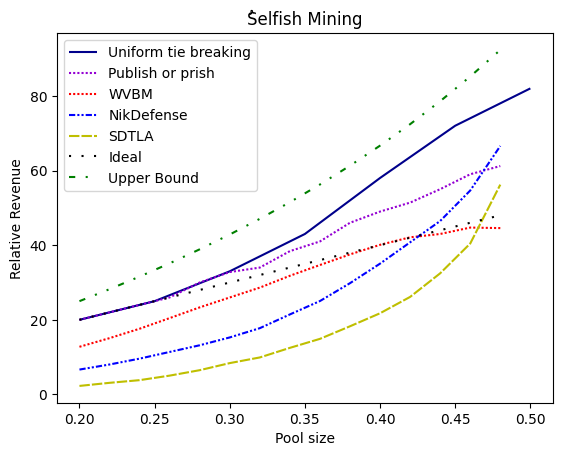

In [16]:
plt.plot(
    alpha_values_five, Tie_Breaking_5, color='darkblue', label='Uniform tie breaking', linestyle=linestyles_dict['solid'], linewidth=1.5)
plt.plot(
    alpha_values, Pubblish_Or_Perish, color='darkviolet', label='Publish or prish', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
plt.plot(
    alpha_values, WVBM_revenue_final, color='r', label='WVBM', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
plt.plot(
    alpha_values, nik_defense_revenue_final, color='b', label='NikDefense', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
plt.plot(
    alpha_values, SDTLA_revenue_final, color='y', label='SDTLA', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)

plt.plot(alpha_values, ideal_defense_revenue_value,
         color='k', label='Ideal', linestyle=linestyles_dict['dotted'], linewidth=1.5)
plt.plot(
    alpha_values, upper_bound_value, color='g', label='Upper Bound', linestyle=linestyles_dict['dashdotdotted'], linewidth=1.5)

plt.title('ُSelfish Mining')
plt.xlabel('Pool size')
plt.ylabel('Relative Revenue')

plt.legend(loc="upper left")

plt.show()

In [ ]:
WVBM_ds_final = []
total = 0
for elements in zip(*WVBM_ds):
    total = sum(elements)
    WVBM_ds_final.append(total)

for i in range(len(WVBM_ds_final)):
    WVBM_ds_final[i] /= divisor

In [ ]:
SDTLA_ds_final = []
total = 0
for elements in zip(*SDTLA_ds):
    total = sum(elements)
    SDTLA_ds_final.append(total)

for i in range(len(SDTLA_ds_final)):
    SDTLA_ds_final[i] /= divisor

In [ ]:
nik_defense_12_ds_final = []
total = 0
for elements in zip(*nik_defense_12_ds):
    total = sum(elements)
    nik_defense_12_ds_final.append(total)

for i in range(len(nik_defense_12_ds_final)):
    nik_defense_12_ds_final[i] /= divisor

In [ ]:
nik_defense_ds_final = []
total = 0
for elements in zip(*nik_defense_ds):
    total = sum(elements)
    nik_defense_ds_final.append(total)

for i in range(len(nik_defense_ds_final)):
    nik_defense_ds_final[i] /= divisor

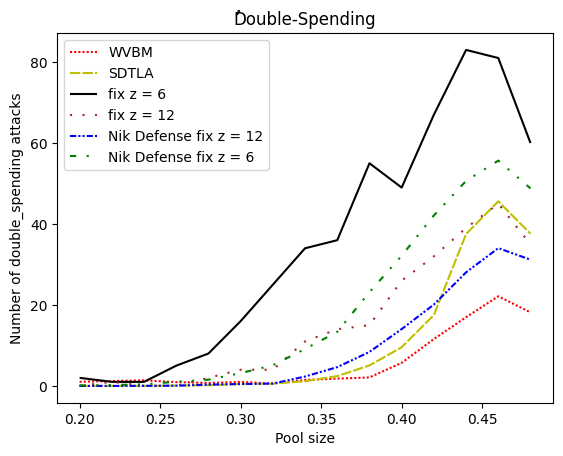

In [ ]:
plt.plot(
    alpha_values_ds, WVBM_ds_final[:], color='r', label='WVBM', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, defense_2_ds[:-1], color='b', label='BlocksInTow=9', linestyle=linestyles_dict['densely dashdotdotted'],  linewidth=1.5)
plt.plot(
    alpha_values_ds, SDTLA_ds_final[:], color='y', label='SDTLA', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
plt.plot(
    alpha_values_ds, withhout_defense, color='black', label='fix z = 6', linestyle=linestyles_dict['solid'], linewidth=1.5)
# plt.plot(
#     alpha_values_ds, nik_defense_ds, color='brown', label='Nik Defense', linestyle=linestyles_dict['dotted'], linewidth=1.5)
plt.plot(
    alpha_values_ds, withhout_defense_12, color='brown', label='fix z = 12', linestyle=linestyles_dict['dotted'], linewidth=1.5)
plt.plot(
    alpha_values_ds, nik_defense_12_ds_final[:], color='b', label='Nik Defense fix z = 12', linestyle=linestyles_dict['densely dashdotdotted'], linewidth=1.5)
plt.plot(
    alpha_values_ds, nik_defense_ds_final[:], color='green', label='Nik Defense fix z = 6', linestyle=linestyles_dict['dashdotdotted'], linewidth=1.5)

plt.title('ُDouble-Spending')
plt.xlabel('Pool size')
plt.ylabel('Number of double_spending attacks')

plt.legend(loc="upper left")

plt.show()

In [ ]:
WVBM_ds_totz_final = []
total = 0
for elements in zip(*WVBM_ds_totz):
    total = sum(elements)
    WVBM_ds_totz_final.append(total)
WVBM_ds_cntz_final = []
total = 0
for elements in zip(*WVBM_ds_cntz):
    total = sum(elements)
    WVBM_ds_cntz_final.append(total)

In [ ]:
SDTLA_ds_totz_final = []
total = 0
for elements in zip(*SDTLA_ds_totz):
    total = sum(elements)
    SDTLA_ds_totz_final.append(total)
SDTLA_ds_cntz_final = []
total = 0
for elements in zip(*SDTLA_ds_cntz):
    total = sum(elements)
    SDTLA_ds_cntz_final.append(total)

In [ ]:
print ("mean_z for WVBM = ",sum(WVBM_ds_totz_final)/sum(WVBM_ds_cntz_final))
print ("\n")
print ("mean_z for SDTLA = ",sum(SDTLA_ds_totz_final)/sum(SDTLA_ds_cntz_final))

mean_z for WVBM =  7.865896444248625


mean_z for SDTLA =  17.70854271356784


In [ ]:



iteration_number = 10000

tow_number = 12

reward_rate = 0.1
penalty_rate = 0.01

min_tow_block_number_1 = 4
max_tow_block_number_1 = 6

min_k = 1
max_k = 3
min_z = 3
max_z = 8
alpha_values = [x / 100 for x in range(20, 50) if x % 2 == 0]
alpha_values_ds = [x / 100 for x in range(20, 50) if x % 2 == 0]
WVBM_1 = WVBM(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
SDTLA_1 = SDTLA(
    tow_number, min_tow_block_number_1, max_tow_block_number_1, reward_rate, penalty_rate, min_k, max_k, 3, 14, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
WVBM_1.gamma = 0.5
SDTLA_1.gamma = 0.5

min_tow_block_number_2 = 8
max_tow_block_number_2 = 10

WVBM_2 = WVBM(
    tow_number, min_tow_block_number_2, max_tow_block_number_2, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
SDTLA_2 = SDTLA(
    tow_number, min_tow_block_number_2, max_tow_block_number_2, reward_rate, penalty_rate, min_k, max_k, 3, 14, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
WVBM_2.gamma = 0.5
SDTLA_2.gamma = 0.5


min_tow_block_number_3 = 14
max_tow_block_number_3 = 16

WVBM_3 = WVBM(
    tow_number, min_tow_block_number_3, max_tow_block_number_3, reward_rate, penalty_rate, min_k, max_k, min_z, max_z, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
SDTLA_3 = SDTLA(
    tow_number, min_tow_block_number_3, max_tow_block_number_3, reward_rate, penalty_rate, min_k, max_k, 3, 14, LearningAutomataType.AVDHLA, LearningAutomataType.AVDHLA, False)
WVBM_3.gamma = 0.5
SDTLA_3.gamma = 0.5



WVBM_1_revenue = [[] for _ in range(50)]
WVBM_1_stale_block = [[] for _ in range(50)]
WVBM_1_ds = [[] for _ in range(50)]
WVBM_1_ds_totz = [[] for _ in range(50)]
WVBM_1_ds_cntz = [[] for _ in range(50)]

WVBM_2_revenue = [[] for _ in range(50)]
WVBM_2_stale_block = [[] for _ in range(50)]
WVBM_2_ds = [[] for _ in range(50)]
WVBM_2_ds_totz = [[] for _ in range(50)]
WVBM_2_ds_cntz = [[] for _ in range(50)]

WVBM_3_revenue = [[] for _ in range(50)]
WVBM_3_stale_block = [[] for _ in range(50)]
WVBM_3_ds = [[] for _ in range(50)]
WVBM_3_ds_totz = [[] for _ in range(50)]
WVBM_3_ds_cntz = [[] for _ in range(50)]

SDTLA_1_revenue = [[] for _ in range(50)]
SDTLA_1_stale_block = [[] for _ in range(50)]
SDTLA_1_ds = [[] for _ in range(50)]
SDTLA_1_ds_totz = [[] for _ in range(50)]
SDTLA_1_ds_cntz = [[] for _ in range(50)]

SDTLA_2_revenue = [[] for _ in range(50)]
SDTLA_2_stale_block = [[] for _ in range(50)]
SDTLA_2_ds = [[] for _ in range(50)]
SDTLA_2_ds_totz = [[] for _ in range(50)]
SDTLA_2_ds_cntz = [[] for _ in range(50)]

SDTLA_3_revenue = [[] for _ in range(50)]
SDTLA_3_stale_block = [[] for _ in range(50)]
SDTLA_3_ds = [[] for _ in range(50)]
SDTLA_3_ds_totz = [[] for _ in range(50)]
SDTLA_3_ds_cntz = [[] for _ in range(50)]


for i in range (50):
    for alpha in alpha_values:
        WVBM_1.reset()
        SDTLA_1.reset()
        WVBM_2.reset()
        SDTLA_2.reset()
        WVBM_3.reset()
        SDTLA_3.reset()
        WVBM_1.alpha = alpha
        SDTLA_1.alpha = alpha
        WVBM_2.alpha = alpha
        SDTLA_2.alpha = alpha
        WVBM_3.alpha = alpha
        SDTLA_3.alpha = alpha

        WVBM_1.start_simulate(iteration_number)
        SDTLA_1.start_simulate(iteration_number)
        WVBM_2.start_simulate(iteration_number)
        SDTLA_2.start_simulate(iteration_number)
        WVBM_3.start_simulate(iteration_number)
        SDTLA_3.start_simulate(iteration_number)

        WVBM_1_revenue[i].append(WVBM_1.revenue)
        SDTLA_1_revenue[i].append(SDTLA_1.revenue)
        WVBM_2_revenue[i].append(WVBM_2.revenue)
        SDTLA_2_revenue[i].append(SDTLA_2.revenue)
        WVBM_3_revenue[i].append(WVBM_3.revenue)
        SDTLA_3_revenue[i].append(SDTLA_3.revenue)

        WVBM_1_stale_block[i].append(WVBM_1.stale_block)
        SDTLA_1_stale_block[i].append(SDTLA_1.stale_block)
        WVBM_2_stale_block[i].append(WVBM_2.stale_block)
        SDTLA_2_stale_block[i].append(SDTLA_2.stale_block)
        WVBM_3_stale_block[i].append(WVBM_3.stale_block)
        SDTLA_3_stale_block[i].append(SDTLA_3.stale_block)

        WVBM_1_ds[i].append(WVBM_1.double_spending_numbers)
        WVBM_1_ds_totz[i].append(WVBM_1.zcount_numbers)
        WVBM_1_ds_cntz[i].append(WVBM_1.countcount)
        SDTLA_1_ds[i].append(SDTLA_1.double_spending_numbers)
        SDTLA_1_ds_totz[i].append(SDTLA_1.zcount_numbers)
        SDTLA_1_ds_cntz[i].append(SDTLA_1.countcount)

        WVBM_2_ds[i].append(WVBM_2.double_spending_numbers)
        WVBM_2_ds_totz[i].append(WVBM_2.zcount_numbers)
        WVBM_2_ds_cntz[i].append(WVBM_2.countcount)
        SDTLA_2_ds[i].append(SDTLA_2.double_spending_numbers)
        SDTLA_2_ds_totz[i].append(SDTLA_2.zcount_numbers)
        SDTLA_2_ds_cntz[i].append(SDTLA_2.countcount)

        WVBM_3_ds[i].append(WVBM_3.double_spending_numbers)
        WVBM_3_ds_totz[i].append(WVBM_3.zcount_numbers)
        WVBM_3_ds_cntz[i].append(WVBM_3.countcount)
        SDTLA_3_ds[i].append(SDTLA_3.double_spending_numbers)
        SDTLA_3_ds_totz[i].append(SDTLA_3.zcount_numbers)
        SDTLA_3_ds_cntz[i].append(SDTLA_3.countcount)





linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])





Streaming output truncated to the last 5000 lines.
k =  3
12
k =  3
24
k =  3
24
k =  3
12
k =  3
24
k =  3
24
k =  3
12
k =  2
24
k =  1
24
k =  2
12
k =  2
24
k =  1
24
k =  2
12
k =  2
24
k =  2
24
k =  2
12
k =  1
24
k =  2
24
k =  2
12
k =  2
24
k =  2
24
k =  2
12
k =  2
24
k =  2
24
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k =  3
12
k =  3
6
k =  3
12
k

In [ ]:
divisor = 50

In [ ]:
WVBM_1_revenue_final = []
total = 0
for elements in zip(*WVBM_1_revenue):
    total = sum(elements)
    WVBM_1_revenue_final.append(total)

for i in range(len(WVBM_1_revenue_final)):
    WVBM_1_revenue_final[i] /= divisor

In [ ]:
WVBM_2_revenue_final = []
total = 0
for elements in zip(*WVBM_2_revenue):
    total = sum(elements)
    WVBM_2_revenue_final.append(total)

for i in range(len(WVBM_2_revenue_final)):
    WVBM_2_revenue_final[i] /= divisor

In [ ]:
WVBM_3_revenue_final = []
total = 0
for elements in zip(*WVBM_3_revenue):
    total = sum(elements)
    WVBM_3_revenue_final.append(total)

for i in range(len(WVBM_3_revenue_final)):
    WVBM_3_revenue_final[i] /= divisor

In [ ]:
SDTLA_1_revenue_final = []
total = 0
for elements in zip(*SDTLA_1_revenue):
    total = sum(elements)
    SDTLA_1_revenue_final.append(total)

for i in range(len(SDTLA_1_revenue_final)):
    SDTLA_1_revenue_final[i] /= divisor

In [ ]:
SDTLA_2_revenue_final = []
total = 0
for elements in zip(*SDTLA_2_revenue):
    total = sum(elements)
    SDTLA_2_revenue_final.append(total)

for i in range(len(SDTLA_2_revenue_final)):
    SDTLA_2_revenue_final[i] /= divisor

In [ ]:
SDTLA_3_revenue_final = []
total = 0
for elements in zip(*SDTLA_3_revenue):
    total = sum(elements)
    SDTLA_3_revenue_final.append(total)

for i in range(len(SDTLA_3_revenue_final)):
    SDTLA_3_revenue_final[i] /= divisor

In [ ]:
ideal_defense_revenue_value = []
upper_bound_value = []

In [ ]:
for alpha in alpha_values:
    ideal_defense_revenue_value.append(alpha * 100)

for alpha in alpha_values:
    upper_bound_value.append(alpha / (1 - alpha) * 100)

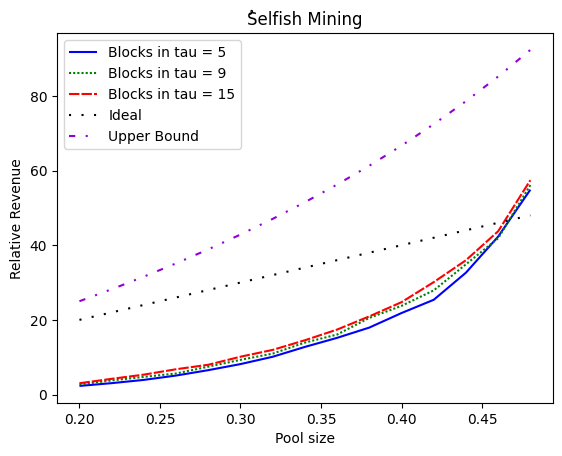

In [ ]:
plt.plot(
    alpha_values,  SDTLA_1_revenue_final, color='b', label='Blocks in tau = 5', linestyle=linestyles_dict['solid'], linewidth=1.5)
plt.plot(
    alpha_values,  SDTLA_2_revenue_final, color='g', label='Blocks in tau = 9', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
plt.plot(
    alpha_values, SDTLA_3_revenue_final, color='r', label='Blocks in tau = 15', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)
plt.plot(alpha_values, ideal_defense_revenue_value,
         color='k', label='Ideal', linestyle=linestyles_dict['dotted'], linewidth=1.5)
plt.plot(
    alpha_values, upper_bound_value, color='darkviolet', label='Upper Bound', linestyle=linestyles_dict['dashdotdotted'], linewidth=1.5)

plt.title('ُSelfish Mining')
plt.xlabel('Pool size')
plt.ylabel('Relative Revenue')

plt.legend(loc="upper left")

plt.show()

In [ ]:
WVBM_1_revenue_final

[12.80886999309371,
 15.129420547980745,
 17.79226461583707,
 20.371458276074872,
 23.063549271618367,
 25.967835904347954,
 29.061425807711622,
 31.90795248300045,
 34.807934734045105,
 37.3707583249008,
 40.0804909073116,
 41.889269501375956,
 43.15136981073026,
 42.3913027533544,
 35.07111930817869]

In [ ]:
WVBM_2_revenue_final

[12.77550790835516,
 15.101489890877216,
 17.63967308217876,
 20.20934019793235,
 22.97942978261141,
 26.248423378783727,
 28.948298955185923,
 31.916229022520437,
 34.672046961352464,
 37.50032898358093,
 40.357089048039654,
 42.161968294362,
 43.02807643267397,
 41.926305887793475,
 35.56800798748017]

In [ ]:
WVBM_3_revenue_final

[12.799866354185394,
 15.215328143420622,
 17.799259570719816,
 20.468208927972587,
 23.20679088171289,
 25.87890791647689,
 28.819033877280646,
 31.826726374498985,
 34.76316557339391,
 37.599458521864456,
 39.724409413735316,
 41.957048184388725,
 42.93948705834522,
 42.29518171270468,
 35.779916809490786]

In [ ]:
SDTLA_1_revenue_final

[2.309525133159767,
 3.053441295178896,
 3.9243222467656778,
 5.089361613324141,
 6.533197340937722,
 8.156229018983058,
 10.120050458890725,
 12.756521130237548,
 15.186972994126407,
 17.938535250122175,
 21.833187749873822,
 25.3796507769647,
 32.643549396914324,
 42.307708034459694,
 54.88278381955655]

In [ ]:
SDTLA_2_revenue_final

[2.7081592316766048,
 3.7815087507520433,
 4.726842029513701,
 5.638418831672355,
 7.473890340968295,
 9.298213276664125,
 10.964750230234463,
 13.92027155014892,
 16.069746994496764,
 20.52888941717716,
 23.755541492195718,
 27.898329994257473,
 34.88401361859256,
 41.85853594376195,
 56.11231631990894]

In [ ]:
SDTLA_3_revenue_final

[3.025440661981749,
 4.209583261603558,
 5.333682964635357,
 6.776702872164339,
 7.974513962895509,
 10.133406681485788,
 11.958397619160275,
 14.541452994882496,
 17.403145690251463,
 20.936364665894963,
 24.739603087806174,
 30.110350203105526,
 35.97432330321986,
 43.73721905680719,
 57.42169537001729]

In [ ]:
WVBM_1_ds_final = []
total = 0
for elements in zip(*WVBM_1_ds):
    total = sum(elements)
    WVBM_1_ds_final.append(total)

for i in range(len(WVBM_1_ds_final)):
    WVBM_1_ds_final[i] /= divisor

In [ ]:
WVBM_2_ds_final = []
total = 0
for elements in zip(*WVBM_2_ds):
    total = sum(elements)
    WVBM_2_ds_final.append(total)

for i in range(len(WVBM_2_ds_final)):
    WVBM_2_ds_final[i] /= divisor

In [ ]:
WVBM_3_ds_final = []
total = 0
for elements in zip(*WVBM_3_ds):
    total = sum(elements)
    WVBM_3_ds_final.append(total)

for i in range(len(WVBM_3_ds_final)):
    WVBM_3_ds_final[i] /= divisor

In [ ]:
SDTLA_1_ds_final = []
total = 0
for elements in zip(*SDTLA_1_ds):
    total = sum(elements)
    SDTLA_1_ds_final.append(total)

for i in range(len(SDTLA_1_ds_final)):
    SDTLA_1_ds_final[i] /= divisor

In [ ]:
SDTLA_2_ds_final = []
total = 0
for elements in zip(*SDTLA_2_ds):
    total = sum(elements)
    SDTLA_2_ds_final.append(total)

for i in range(len(SDTLA_2_ds_final)):
    SDTLA_2_ds_final[i] /= divisor

In [ ]:
SDTLA_3_ds_final = []
total = 0
for elements in zip(*SDTLA_3_ds):
    total = sum(elements)
    SDTLA_3_ds_final.append(total)

for i in range(len(SDTLA_3_ds_final)):
    SDTLA_3_ds_final[i] /= divisor

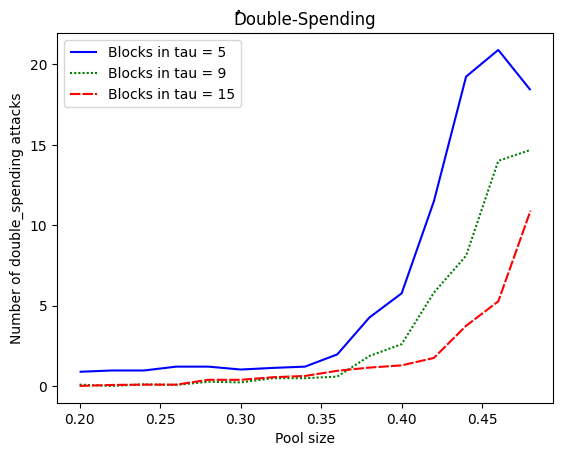

In [ ]:
plt.plot(
    alpha_values_ds, WVBM_1_ds_final[:], color='b', label='Blocks in tau = 5', linestyle=linestyles_dict['solid'], linewidth=1.5)
plt.plot(
    alpha_values_ds, WVBM_2_ds_final[:], color='g', label='Blocks in tau = 9', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
plt.plot(
    alpha_values_ds, WVBM_3_ds_final[:], color='r', label='Blocks in tau = 15', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)

plt.title('ُDouble-Spending')
plt.xlabel('Pool size')
plt.ylabel('Number of double_spending attacks')

plt.legend(loc="upper left")

plt.show()

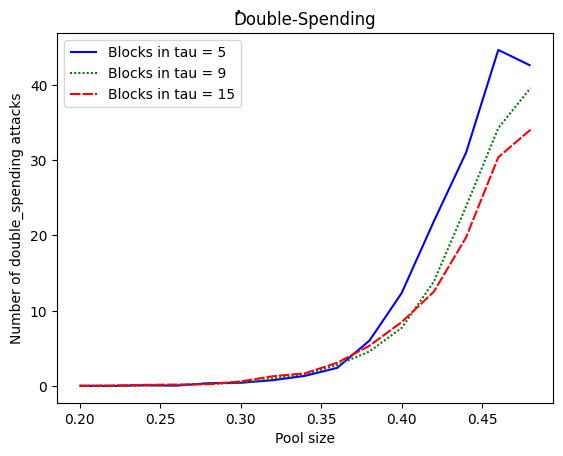

In [ ]:
plt.plot(
    alpha_values_ds, SDTLA_1_ds_final[:], color='b', label='Blocks in tau = 5', linestyle=linestyles_dict['solid'], linewidth=1.5)
plt.plot(
    alpha_values_ds, SDTLA_2_ds_final[:], color='g', label='Blocks in tau = 9', linestyle=linestyles_dict['densely dotted'], linewidth=1.5)
plt.plot(
    alpha_values_ds, SDTLA_3_ds_final[:], color='r', label='Blocks in tau = 15', linestyle=linestyles_dict['densely dashed'], linewidth=1.5)

plt.title('ُDouble-Spending')
plt.xlabel('Pool size')
plt.ylabel('Number of double_spending attacks')

plt.legend(loc="upper left")

plt.show()